# SI 650 Homework 3
- Run this notebook as a sanity check for your implementation

##### Creating search pipelines for two different ranking strategies.

* Pipeline 1: Initial ranking by BM25 with re-ranking by LambdaMART (Cross-encoder feature enabled)

* Pipeline 2: Initial ranking by Bi-Encoder vector ranker with re-ranking by LambdaMART (Cross-encoder feature enabled)

The corpus for the main index is augmented by doc2query queries

In [1]:
import csv
from collections import Counter, defaultdict
from tqdm import tqdm
import json
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

# your modules are imported here
from indexing import Indexer, IndexType, BasicInvertedIndex
from document_preprocessor import RegexTokenizer, Doc2QueryAugmenter, read_dataset
from ranker import Ranker, BM25, CrossEncoderScorer
from vector_ranker import VectorRanker
from network_features import NetworkFeatures
from l2r import L2RFeatureExtractor, L2RRanker

from sentence_transformers import SentenceTransformer
from relevance import map_score, ndcg_score, run_relevance_tests
import torch

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from importlib import reload
# import l2r
# reload(l2r)
# from l2r import L2RFeatureExtractor, L2RRanker

In [3]:
# change these to point to actual file paths
STOPWORD_PATH = 'stopwords.txt'
DATASET_PATH = 'wikipedia_200k_dataset.jsonl.gz'
EDGELIST_PATH = 'edgelist.csv.gz'
NETWORK_STATS_PATH = 'network_stats.csv'
DOC_CATEGORY_INFO_PATH = 'doc_category_info.json'
RECOGNIZED_CATEGORY_PATH = 'recognized_categories.txt'
DOC2QUERY_PATH = 'doc2query.csv'
MAIN_INDEX = 'main_index_augmented'
TITLE_INDEX = 'title_index'
RELEVANCE_TRAIN_DATA = 'hw3_relevance.train.csv'
ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA = 'wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy'
DOCUMENT_ID_TEXT = 'document-ids.txt'

### Load Basic Statistics

In [4]:
# Load in the stopwords

stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 543'

In [5]:
# # Get the list of categories for each page (either compute it or load the pre-computed list)
# docid_to_categories = {}
# with open(DATASET_PATH, 'rt', encoding='utf-8') as file:
#     for line in tqdm(file, total=200_000):
#         document = json.loads(line)
#         docid_to_categories[document['docid']] = document['categories']
# f'Document categories collected'

In [6]:
# # Get or pre-compute the list of categories at least the minimum number of times (specified in the homework)
# category_counts = Counter()
# for cats in tqdm(docid_to_categories.values(), total=len(docid_to_categories)):
#     for c in cats:
#         category_counts[c] += 1
# recognized_categories = set(
#     [cat for cat, count in category_counts.items() if count >= 1000])
# print("saw %d categories" % len(recognized_categories))

# # Map each document to the smallert set of categories that occur frequently
# doc_category_info = {}
# for docid, cats in tqdm(docid_to_categories.items(), total=len(docid_to_categories)):
#     valid_cats = [c for c in cats if c in recognized_categories]
#     doc_category_info[docid] = valid_cats

In [7]:
doc_category_info = {}
with open(DOC_CATEGORY_INFO_PATH, 'r') as f:
    doc_category_info = json.load(f)
    doc_category_info = {int(k): v for k, v in doc_category_info.items()}

recognized_categories = set()
with open(RECOGNIZED_CATEGORY_PATH, 'r') as f:
    recognized_categories = set(map(lambda x: x.strip(), f.readlines()))

In [8]:
network_features = {}
# Get or load the network statistics for the Wikipedia link network

# if True:
#     nf = NetworkFeatures()
#     print('loading network')
#     graph = nf.load_network(EDGELIST_PATH, total_edges=92650947)
#     print('getting stats')
#     net_feats_df = nf.get_all_network_statistics(graph)
#     graph = None
#     print('Saving')
#     net_feats_df.to_csv(NETWORK_STATS_PATH, index=False)

#     print("converting to dict format")
#     network_features = defaultdict(dict)
#     for i, row in tqdm(net_feats_df.iterrows(), total=len(net_feats_df)):
#         for col in ['pagerank', 'hub_score', 'authority_score']:
#             network_features[row['docid']][col] = row[col]
#     net_feats_df = None
# else:
#     with open(NETWORK_STATS_PATH, 'r', encoding='utf-8') as file:
#         for idx, line in enumerate(file):
#             if idx == 0:
#                 continue
#             else:
#                 # the indexes may change depending on your CSV
#                 splits = line.strip().split(',')
#                 network_features[int(splits[0])] = {
#                     'pagerank': float(splits[1]),
#                     'authority_score': float(splits[2]),
#                     'hub_score': float(splits[3])
#                 }

networks_stats = pd.read_csv(NETWORK_STATS_PATH, index_col=0)
for row in tqdm(networks_stats.iterrows()):
    network_features[row[1]['docid']] = row[1][1:].to_dict()

f'Network stats collection {len(network_features)}'

999841it [00:22, 44733.99it/s]


'Network stats collection 999841'

### Problem 1

In [9]:
model_names = [
    'doc2query/msmarco-t5-base-v1',
    'google/flan-t5-small',
    'google/flan-t5-base',
    'google/flan-t5-large',
]

doc2query_json = defaultdict(dict)
time_json = defaultdict(list)

dataset_name = "wikipedia_200k_dataset.jsonl.gz"
max_docs = 100
batch_size = 1
n_queries = 1

token_key = "text"
pre_prefix_prompt = "Generate a query for the following text: "

for model_name in model_names:
    if model_name == "doc2query/msmarco-t5-base-v1":
        prefix_prompt = ''
    else:
        prefix_prompt = pre_prefix_prompt
    d2q = Doc2QueryAugmenter(model_name)
    queries = {}
    for doc in tqdm(read_dataset(dataset_name, max_docs, batch_size),
            desc=f"Generating queries for {model_name}",
            total=max_docs//batch_size):
        t1 = time.time()
        doc_id = doc["docid"]
        texts = doc[token_key]
        if batch_size > 1:        
            batch_queries = d2q.get_batched_queries(texts, n_queries, prefix_prompt=prefix_prompt)
            for id, doc_queries in zip(doc_id, batch_queries):
                queries[id] = doc_queries
        else:
            queries[doc_id] = d2q.get_queries(texts, n_queries, prefix_prompt=prefix_prompt)
        t2 = time.time()
        time_json[model_name].append(t2-t1)
    doc2query_json[model_name].update(queries)

with open("doc2query.json", "w") as f:
    json.dump(doc2query_json, f, indent=4)

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
Generating queries for doc2query/msmarco-t5-base-v1: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]
Generating queries for google/flan-t5-large: 100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


Text(0.5, 1.0, 'Average time to generate queries per document')

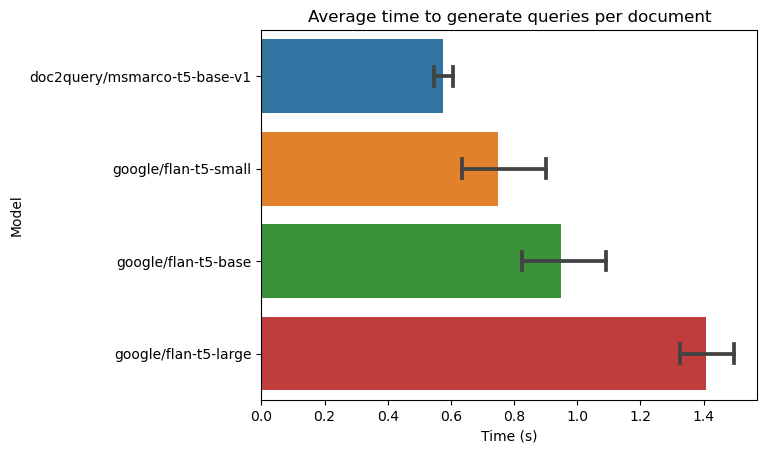

In [10]:
import seaborn as sns

p1_df = pd.DataFrame({
    "model": list(time_json.keys()),
    "time": time_json.values()
}).explode("time").reset_index(drop=True)

with open("doc2query_time.json", "w") as f:
    json.dump(time_json, f, indent=4)

sns.barplot(data=p1_df, y="model", x="time", errorbar="ci", capsize=.2, orient="h")
plt.xlabel("Time (s)")
plt.ylabel("Model")
plt.savefig("doc2query_time.png", dpi=300, bbox_inches="tight")
plt.title("Average time to generate queries per document")

### Augmented Indexing

In [11]:
doc_augment_dict = defaultdict(lambda: [])
# with open(DOC2QUERY_PATH, 'r', encoding='utf-8') as file:
#     dataset = csv.reader(file)
#     for idx, row in tqdm(enumerate(dataset), total=600_000):
#         if idx == 0:
#             continue
#         doc_augment_dict[int(row[0])].append(row[2])

doc2query_df = pd.read_csv(DOC2QUERY_PATH).dropna()
for row in tqdm(doc2query_df.iterrows(), total=len(doc2query_df)):
    doc_id = int(row[1]['doc'])
    doc_query = row[1]['query']
    doc_augment_dict[doc_id].append(doc_query)

100%|██████████| 599565/599565 [00:07<00:00, 83058.86it/s]


In [13]:
# Load or build Inverted Indices for the documents' main text and titles
#
# Estiamted times:
#    Document text token counting: 4 minutes
#    Document text indexing: 5 minutes
#    Title text indexing: 30 seconds
preprocessor = RegexTokenizer('\w+')

# Creating and saving the index

# main_index = Indexer.create_index(
#         IndexType.InvertedIndex, DATASET_PATH, preprocessor,
#         stopwords, 50, doc_augment_dict=doc_augment_dict)
# main_index.save(MAIN_INDEX)

# title_index = Indexer.create_index(
#         IndexType.InvertedIndex, DATASET_PATH, preprocessor,
#         stopwords, 0, text_key='title')
# title_index.save(TITLE_INDEX)

# Loading a preloaded index
main_index = Indexer.load_index(MAIN_INDEX)
title_index = Indexer.load_index(TITLE_INDEX)

load index: 100%|██████████| 90876/90876 [00:00<00:00, 830449.93it/s]


In [14]:
# create the raw text dictionary by going through the wiki dataset
# this dictionary should store only the first 500 words of the raw documents text

raw_text_dict = {}
for doc in tqdm(read_dataset(DATASET_PATH, 200_000, 1), total=200_000):
    doc_id = int(doc['docid'])
    raw_text_dict[doc_id] = " ".join(preprocessor.tokenize(doc['text'])[:500])

100%|██████████| 200000/200000 [01:15<00:00, 2665.92it/s] 


### Problem 2

In [15]:
def fetch_related_docs(relevalce_data_path: str, dataset_path: str):
    relevance_dev_df = pd.read_csv(RELEVANCE_DEV_DATA)
    dev_docids = set(relevance_dev_df['docid'].unique())

    related_docids = []
    related_docs = []
    for doc in tqdm(read_dataset(dataset_path), total=200_000):
        doc_id = int(doc['docid'])
        if doc_id in dev_docids:
            related_docids.append(doc_id)
            related_docs.append(doc['text'])
    return related_docids, related_docs

In [16]:
RELEVANCE_DEV_DATA = "hw3_relevance.dev.csv"
dev_docids, dev_docs = fetch_related_docs(RELEVANCE_DEV_DATA, DATASET_PATH)

100%|██████████| 200000/200000 [00:14<00:00, 13779.38it/s]


##### Generate encoded_docs

In [17]:
bi_encoder_names = [
    "sentence-transformers/msmarco-MiniLM-L12-cos-v5",
    "multi-qa-mpnet-base-dot-v1",
    "msmarco-distilbert-dot-v5"
]

test_filename = 'hw3_relevance.test.csv'

cescorer = None
fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
                         preprocessor, stopwords, recognized_categories,
                         network_features, cescorer)

named_rankers = {}
named_rankers['BM25'] = Ranker(main_index, preprocessor, stopwords, BM25(main_index))

encoder_time_info = {}
for bi_encoder_name in bi_encoder_names:
    encoder = SentenceTransformer(bi_encoder_name)
    if torch.cuda.is_available():
        encoder = encoder.to('cuda')
    elif torch.backends.mps.is_built():
        encoder = encoder.to('mps')
    t1 = time.time()
    encoded_docs = encoder.encode(dev_docs, batch_size=128, show_progress_bar=True, normalize_embeddings=True)
    t2 = time.time()
    encoder_time_info[bi_encoder_name] = t2 - t1
    vector_ranker = VectorRanker(bi_encoder_name, encoded_docs, dev_docids)
    named_rankers[bi_encoder_name] = vector_ranker

Batches: 100%|██████████| 17/17 [04:22<00:00, 15.43s/it]


##### Encoding time

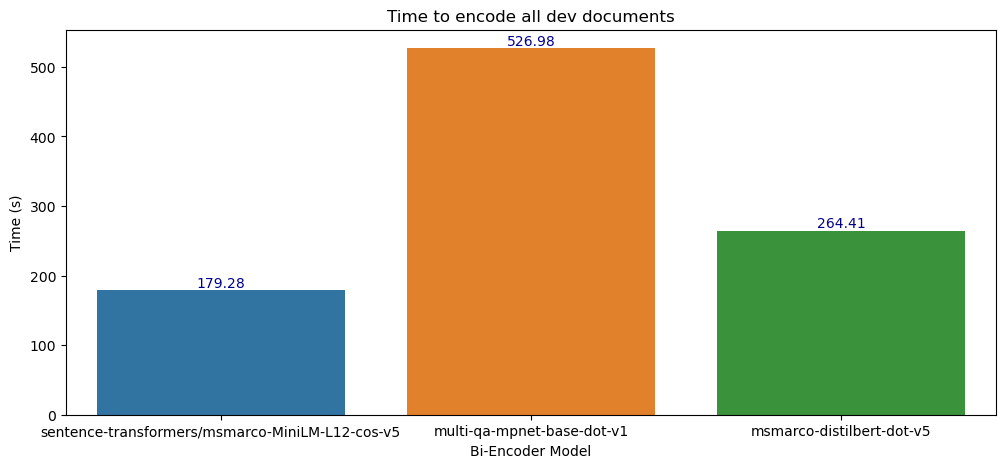

In [18]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(x = list(encoder_time_info.keys()), y = list(encoder_time_info.values()))
ax.bar_label(ax.containers[0], fmt='%.2f', color='darkblue')
plt.xlabel("Bi-Encoder Model")
plt.ylabel("Time (s)")
plt.title("Time to encode all dev documents")
plt.savefig("encoder_time.png", dpi=300, bbox_inches="tight")

##### Save encoded docs

In [19]:
# kwargs = {'docids': dev_docids}
# for name in bi_encoder_names:
#     encoded_docs = named_rankers[name].encoded_docs
#     kwargs[name] = encoded_docs

# np.savez('encoded_docs.npz', **kwargs)
# encoded_docs_dict = np.load('encoded_docs.npz')

##### Evaluate Bi-Encoders

In [20]:
named_pipeline_info = {}
for name, ranker in named_rankers.items():
    print(f"Evaluating {name}")
    pipeline_info = run_relevance_tests(RELEVANCE_DEV_DATA, ranker)
    named_pipeline_info[name] = pipeline_info

Evaluating BM25


100%|██████████| 19/19 [00:10<00:00,  1.80it/s]


Evaluating sentence-transformers/msmarco-MiniLM-L12-cos-v5


100%|██████████| 19/19 [00:00<00:00, 35.74it/s]


Evaluating multi-qa-mpnet-base-dot-v1


100%|██████████| 19/19 [00:00<00:00, 27.60it/s]


Evaluating msmarco-distilbert-dot-v5


100%|██████████| 19/19 [00:00<00:00, 52.98it/s]


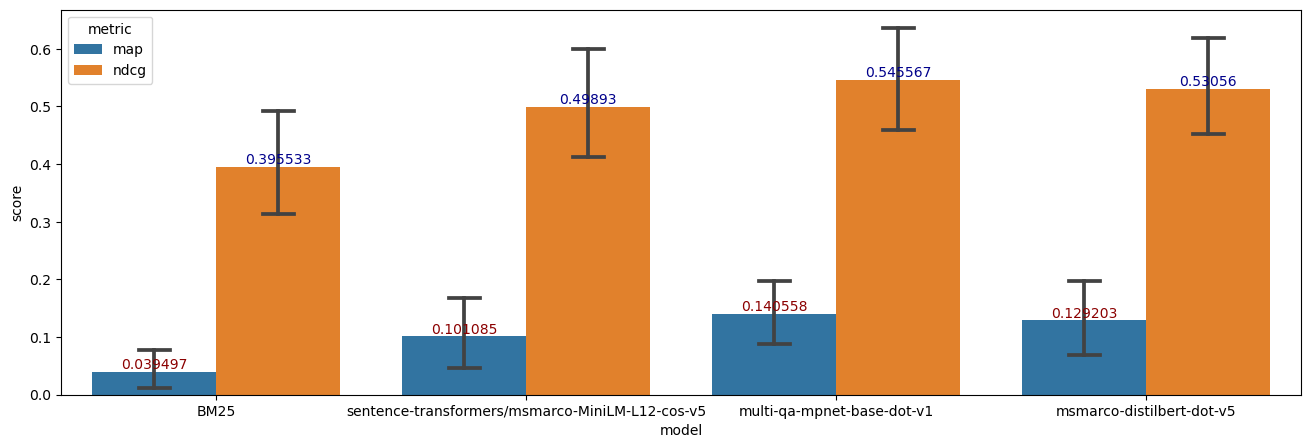

In [21]:
tmp_pipeline_info = pd.DataFrame(named_pipeline_info).transpose().reset_index().rename(columns={'index': 'model'})
metric_add_func = lambda x, name: [(name, v) for v in x]
tmp_pipeline_info['score'] = tmp_pipeline_info[['map_scores', 'ndcg_scores']].apply(lambda x: metric_add_func(x[0], 'map') + metric_add_func(x[1], 'ndcg'), axis=1)
tmp_pipeline_info = tmp_pipeline_info.explode('score')
tmp_pipeline_info['metric'] = tmp_pipeline_info['score'].apply(lambda x: x[0])
tmp_pipeline_info['score'] = tmp_pipeline_info['score'].apply(lambda x: x[1])
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=tmp_pipeline_info, x='model', y='score', hue='metric', capsize=.1, errorbar='ci')
ax.bar_label(ax.containers[0], fontsize=10, color='darkred')
ax.bar_label(ax.containers[1], fontsize=10, color='darkblue')
plt.savefig('bi_encoder_l2r_metrics.png', dpi=300, bbox_inches='tight')

In [22]:
with open('bi_encoder_l2r_metrics.json', 'w') as f:
    json.dump(named_pipeline_info, f, indent=4)

### Problem 3

##### 10 most common labels for each of the four person attribute

In [23]:
top_10_attributes = {}
person_attr_file = "person-attributes.csv"
person_attr_df = pd.read_csv(person_attr_file)
for attr in person_attr_df.columns[1:-1]:
    top_10_attributes[attr] = person_attr_df[attr].value_counts()[:10].to_dict()

with open("top_10_attributes.json", "w") as f:
    f.write(json.dumps(top_10_attributes, indent=4))

top_10_attributes_df = pd.DataFrame(
    {
        k: list(v.keys()) + [''] * (10 - len(v.keys()))
        for k, v in top_10_attributes.items()
    }
)
top_10_attributes_df

,Ethnicity,Gender,Religious_Affiliation,Political_Party
0,African Americans,male,Catholic Church,Democratic Party
1,Jewish people,female,Islam,Republican Party
2,Germans,trans woman,atheism,Conservative Party
3,English people,non-binary,Catholicism,Labour Party
4,French,genderfluid,Hinduism,Indian National Congress
5,American Jews,cisgender man,Judaism,Bharatiya Janata Party
6,Italians,male organism,Christianity,Communist Party of the Soviet Union
7,Greeks,,Lutheranism,Nazi Party
8,Serbs,,Anglicanism,Chinese Communist Party
9,Arabs,,Sunni Islam,Liberal Party


##### Load pre-computed vectors

In [24]:
encoded_docs = None
with open(ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA, 'rb') as file:
    encoded_docs = np.load(file)

with open(DOCUMENT_ID_TEXT, 'r') as f:
    document_ids = f.read().splitlines()
document_ids = [int(x) for x in document_ids]

q3_vector_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5', encoded_docs, document_ids)
queries = ["person", "woman", "teacher", "role model", "professional"]

for query in queries:
    query_scores = {k: v for k, v in q3_vector_ranker.query(query)}
    person_attr_df[query] = person_attr_df['docid'].apply(lambda x: query_scores.get(x, 0))
    person_attr_df[query + "_rank"] = person_attr_df[query].rank(ascending=False, na_option='bottom')

In [25]:
person_attr_df.head()

,title,Ethnicity,Gender,Religious_Affiliation,Political_Party,docid,person,person_rank,woman,woman_rank,teacher,teacher_rank,role model,role model_rank,professional,professional_rank
0,George Washington,NaN,male,Episcopal Church,independent politician,11968,0.059404,7971.0,-0.045185,10262.0,0.038667,8221.0,0.034952,6549.0,0.000710,7767.0
1,Douglas Adams,White British,male,NaN,NaN,8091,0.111642,3431.0,-0.014420,8440.0,0.082106,5513.0,0.037989,6333.0,0.060140,3698.0
2,George W. Bush,NaN,male,United Methodist Church,Republican Party,3414021,0.077822,6372.0,-0.039768,10001.0,0.045824,7761.0,0.049667,5546.0,0.018933,6482.0
3,Diego Velázquez,Spaniards,male,NaN,NaN,77423,0.076067,6537.0,0.008360,6804.0,-0.023389,11067.0,0.034467,6585.0,0.058205,3813.0
4,Augusto Pinochet,NaN,male,Catholicism,independent politician,18933396,0.127831,2280.0,-0.039218,9969.0,-0.029851,11250.0,0.071191,4046.0,-0.021278,9161.0


In [26]:
person_attr_df.to_csv("person-attributes-queries.csv", index=False)

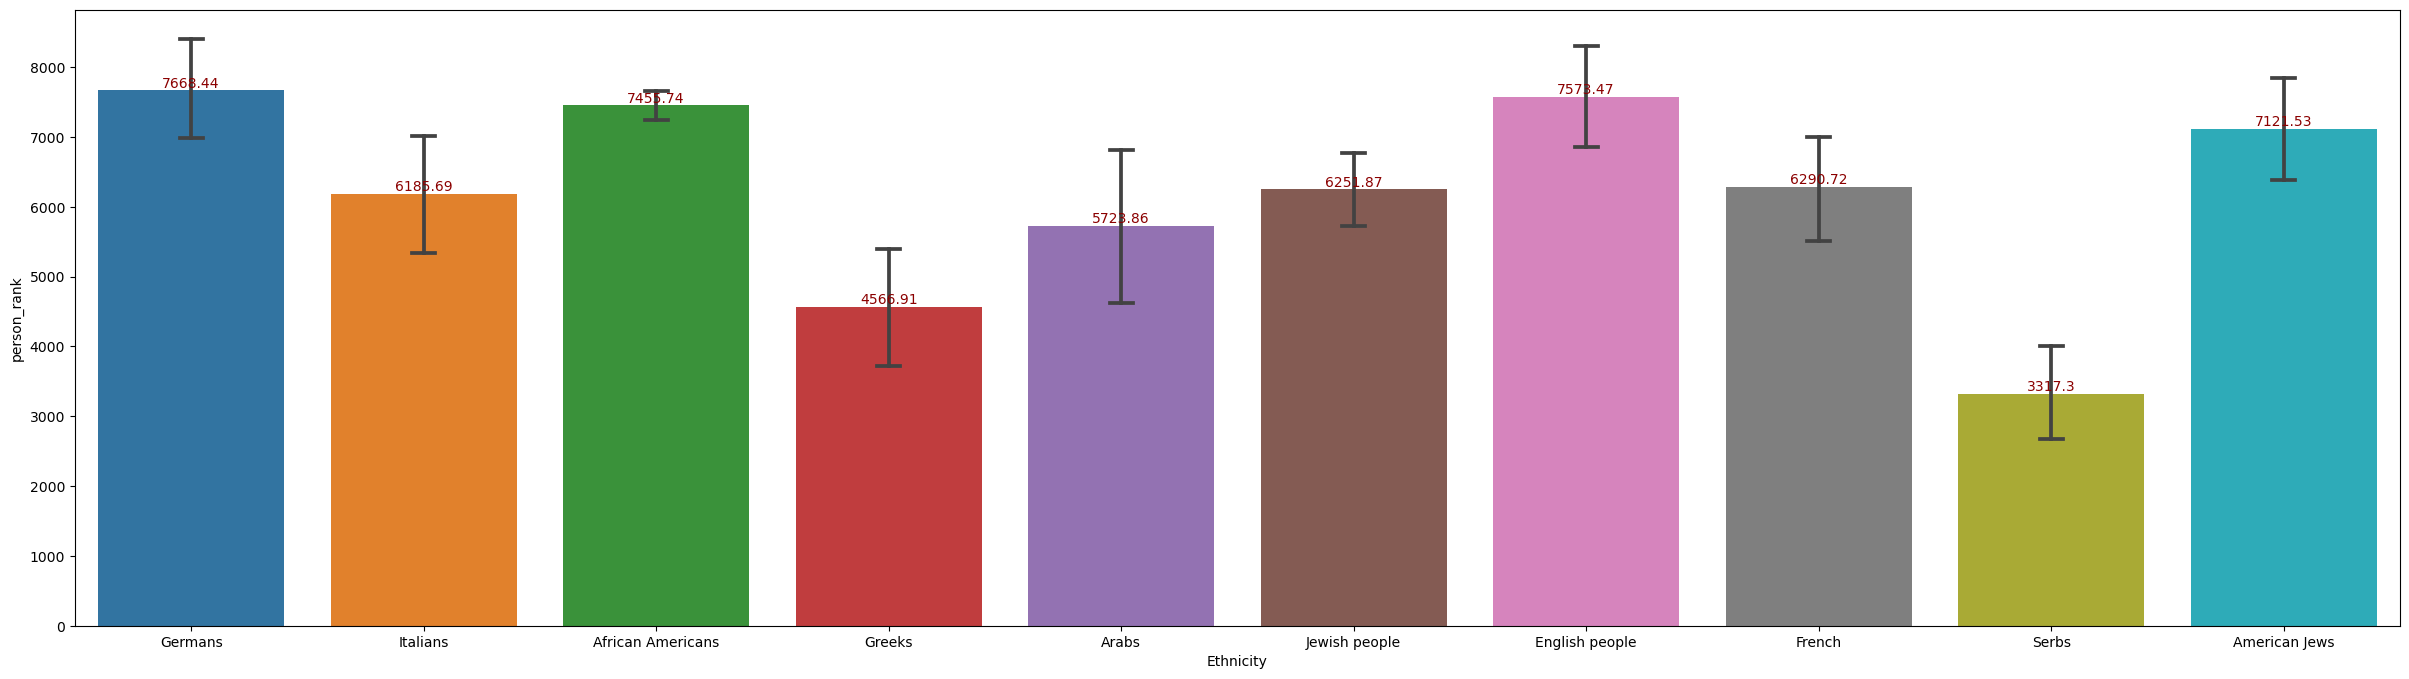

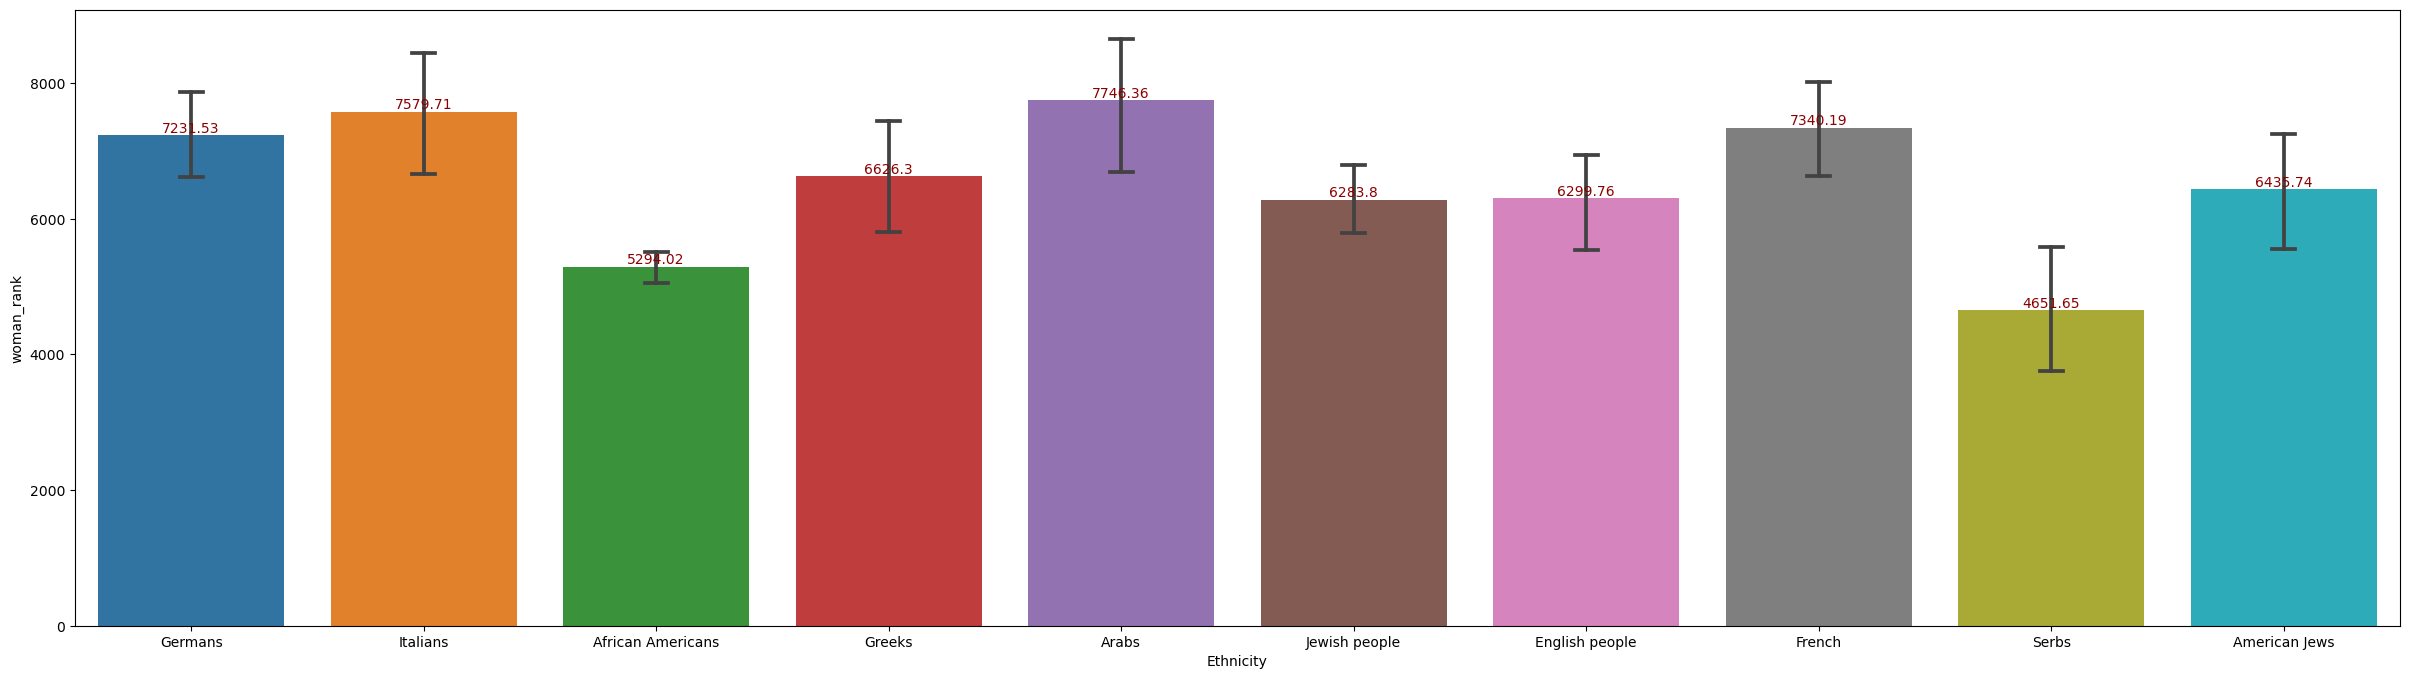

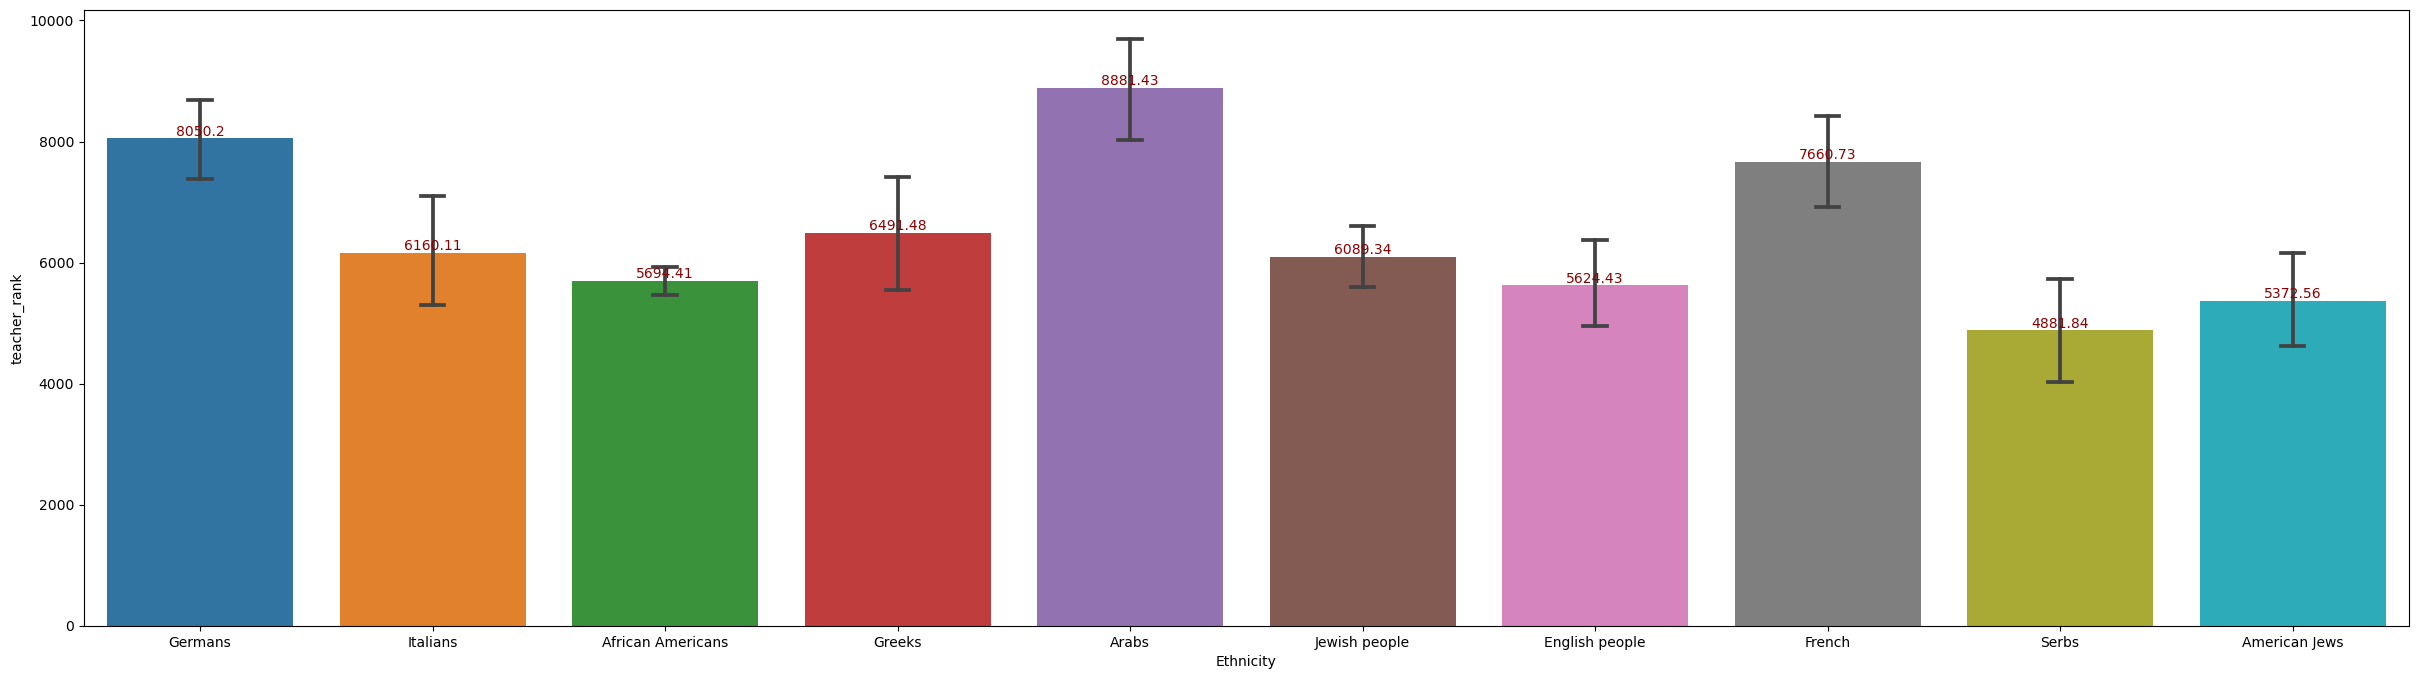

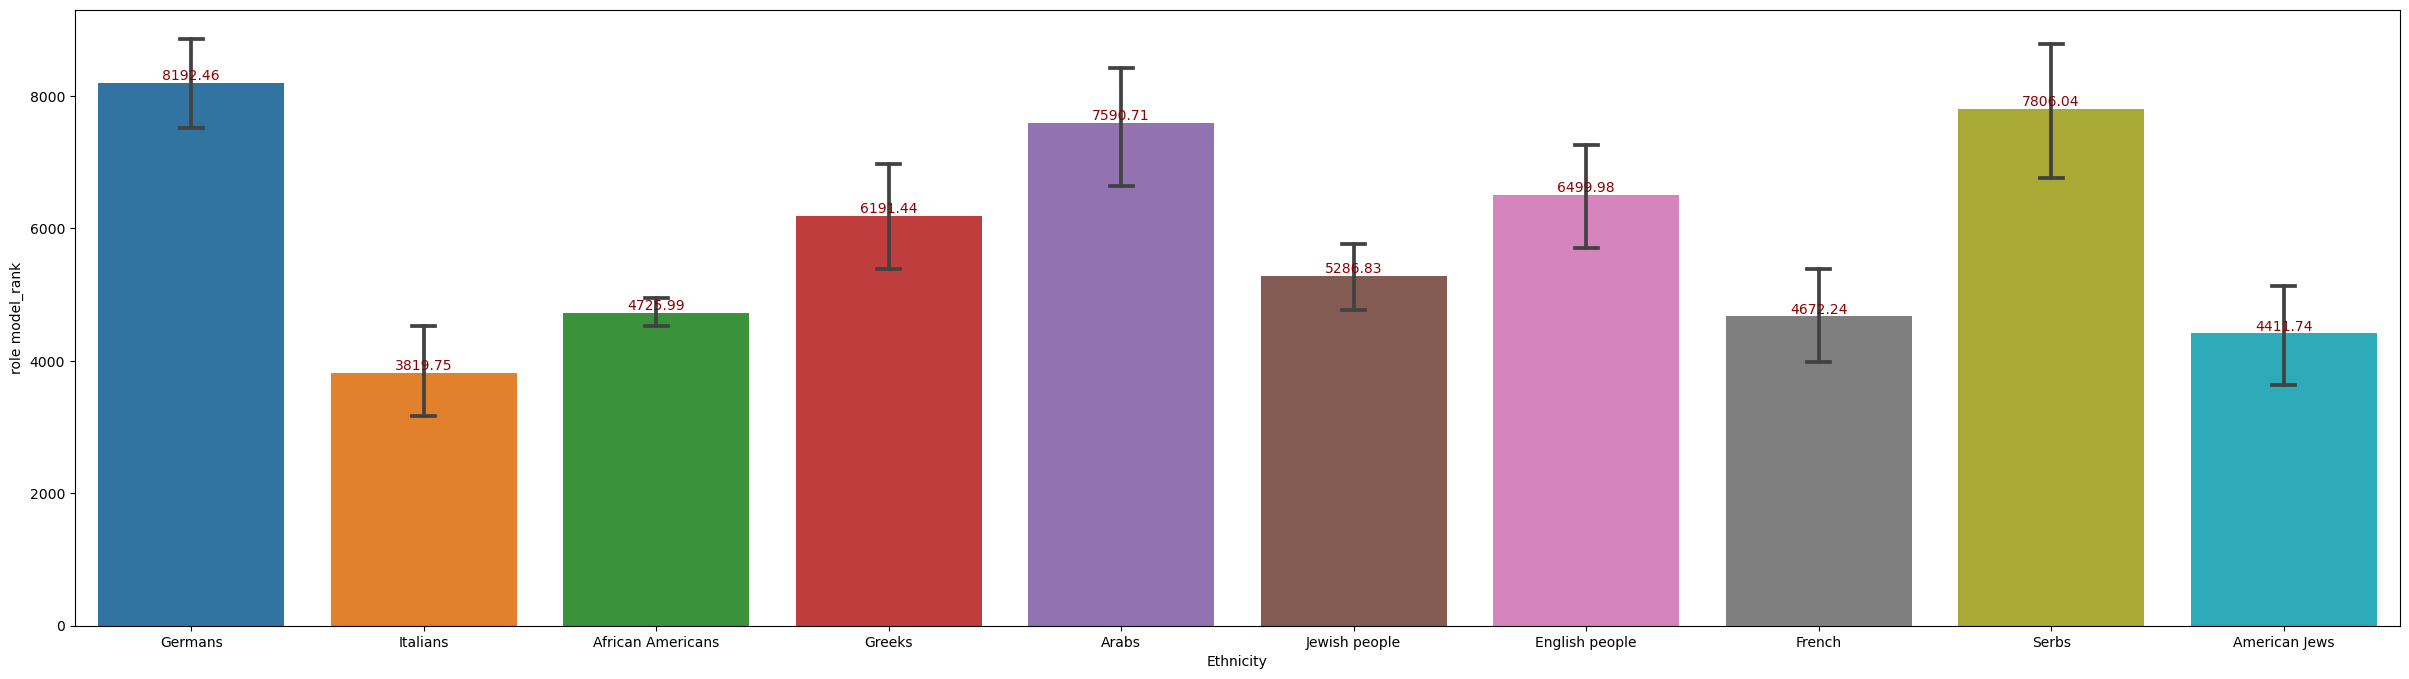

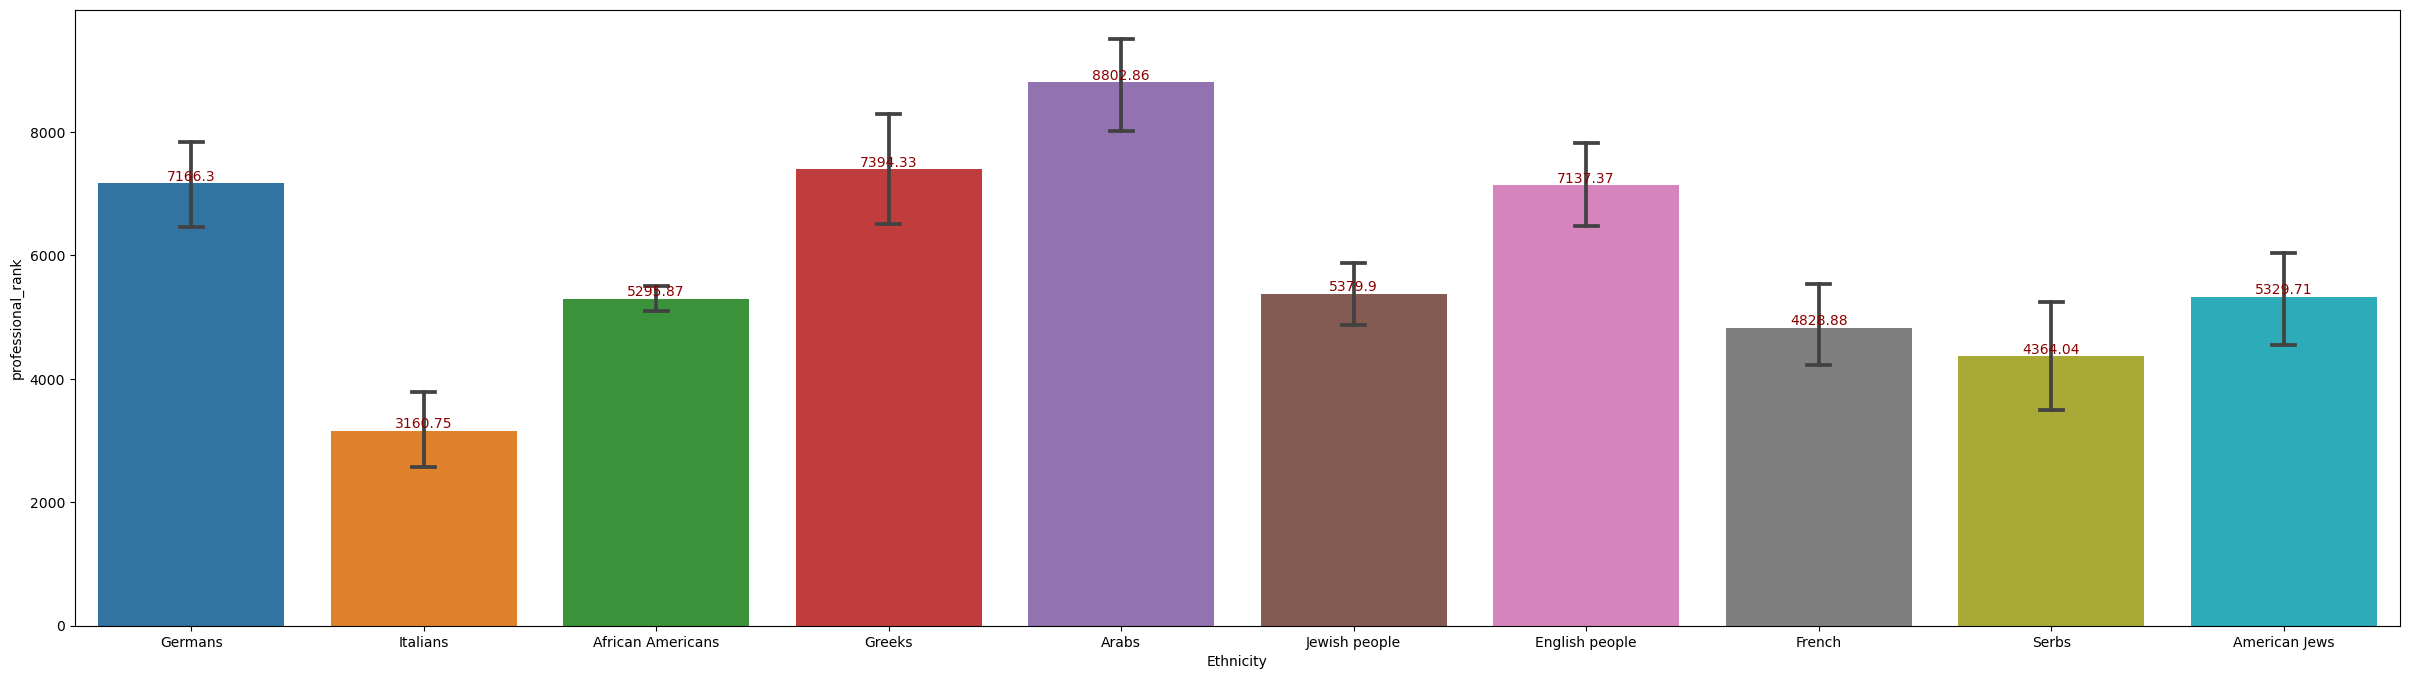

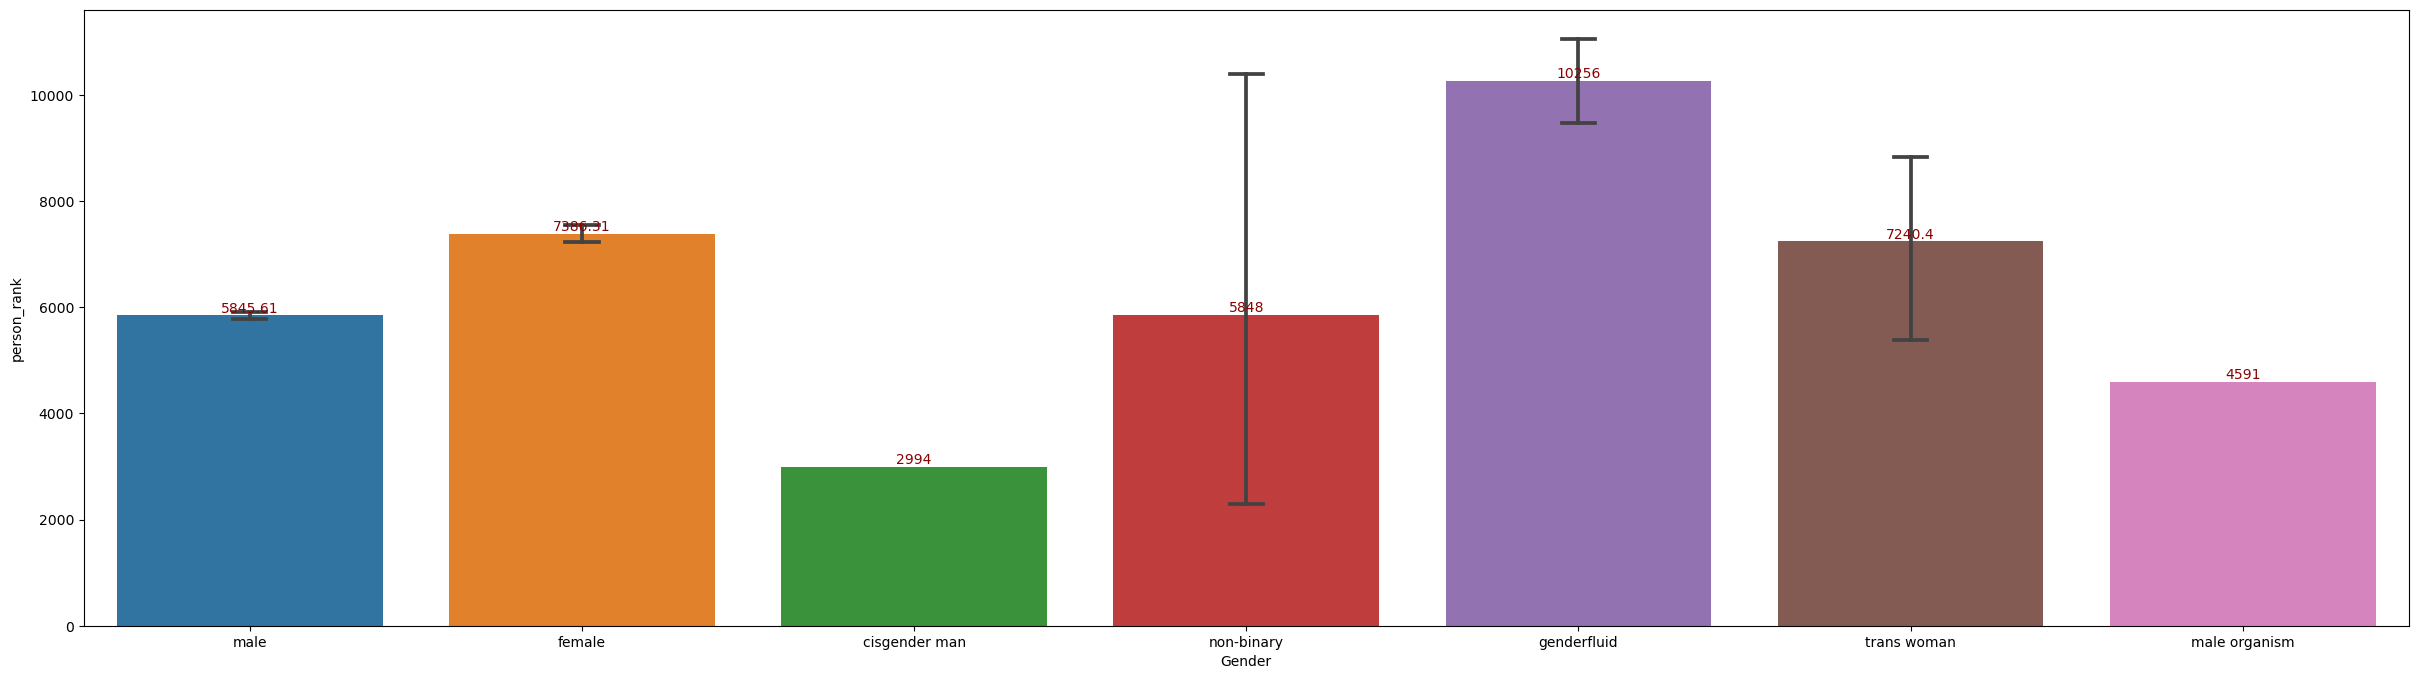

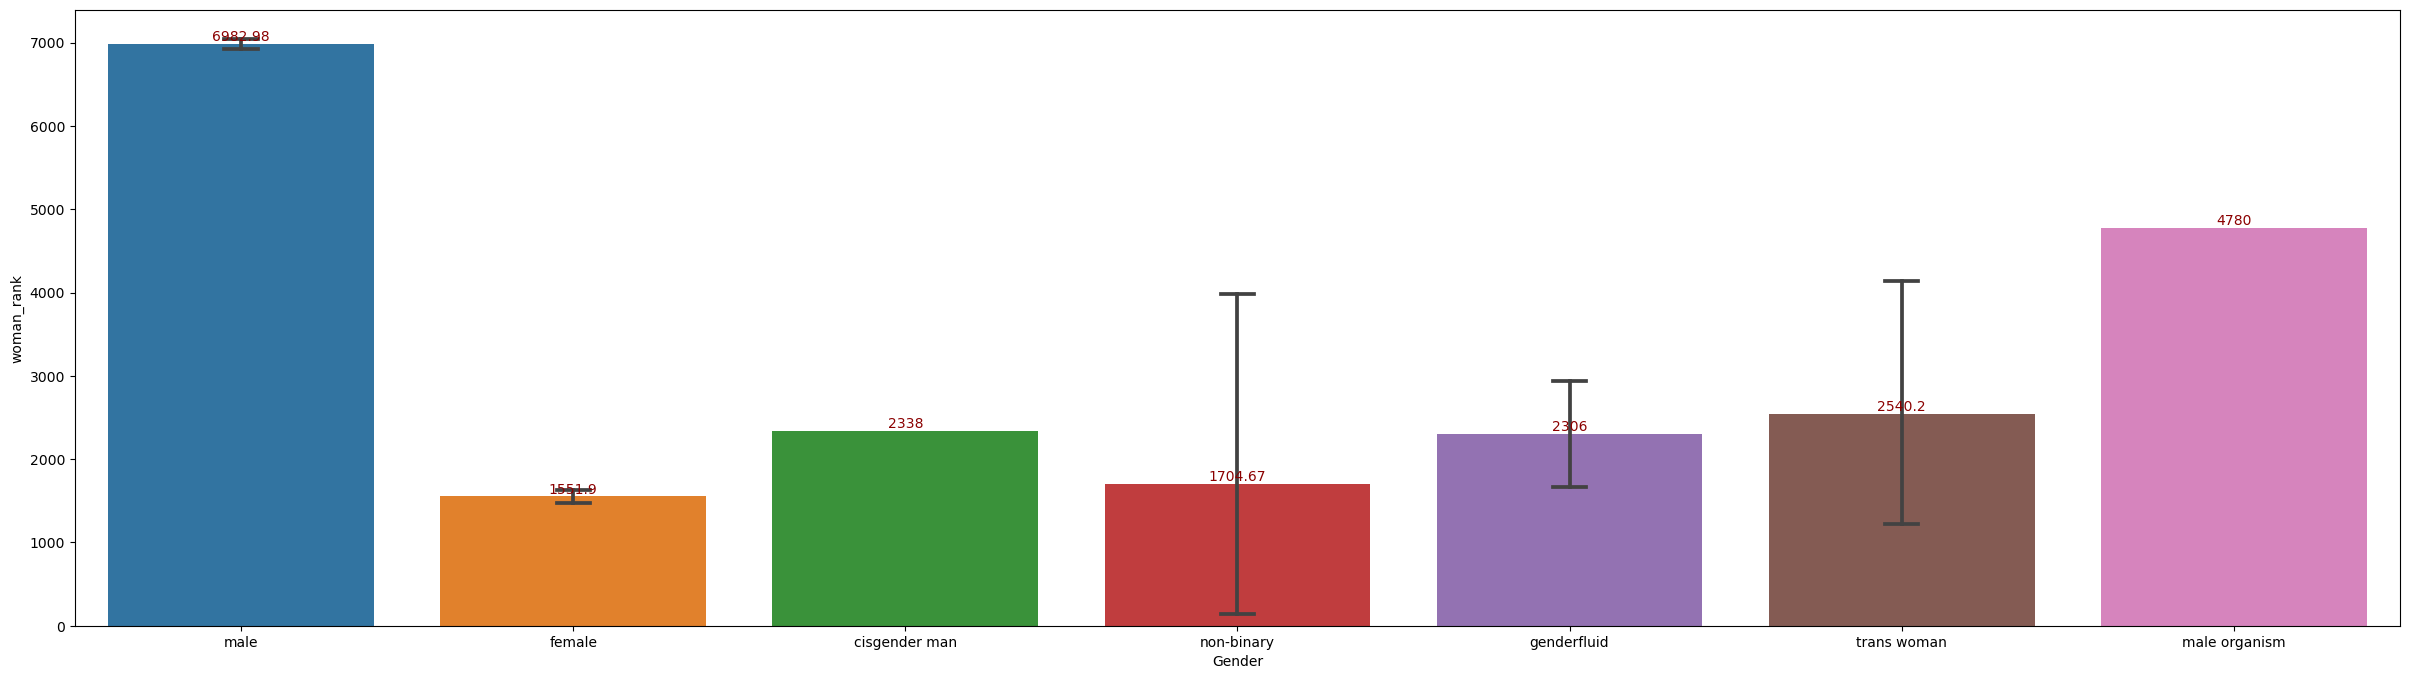

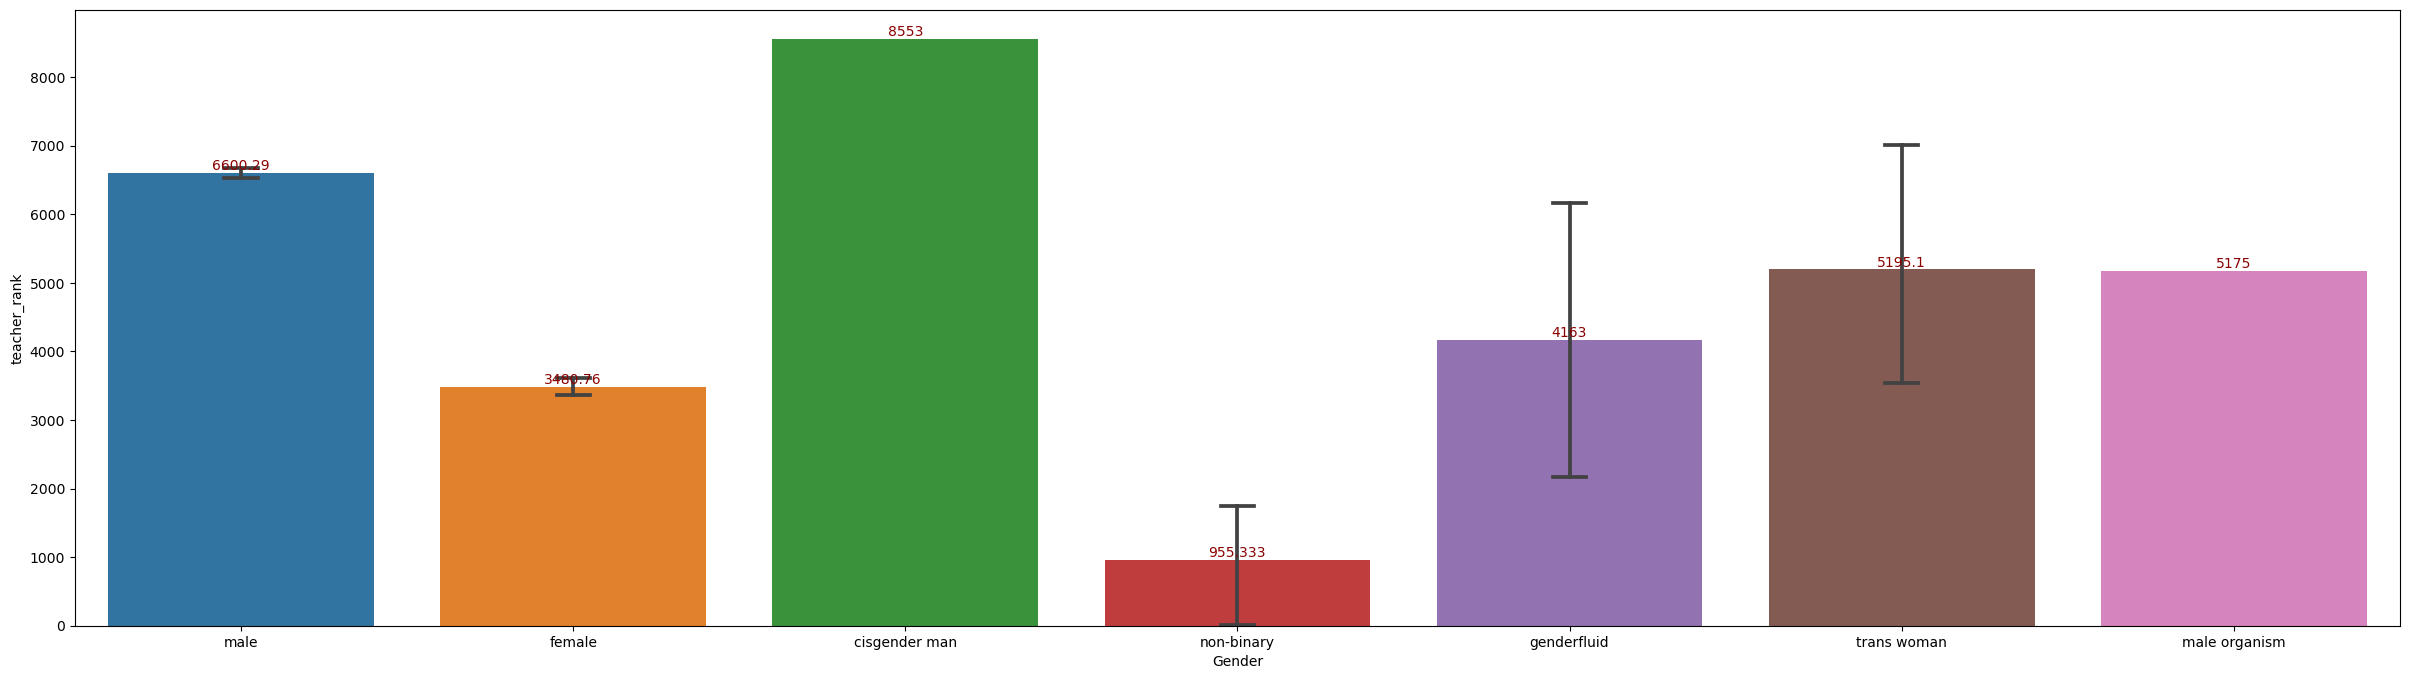

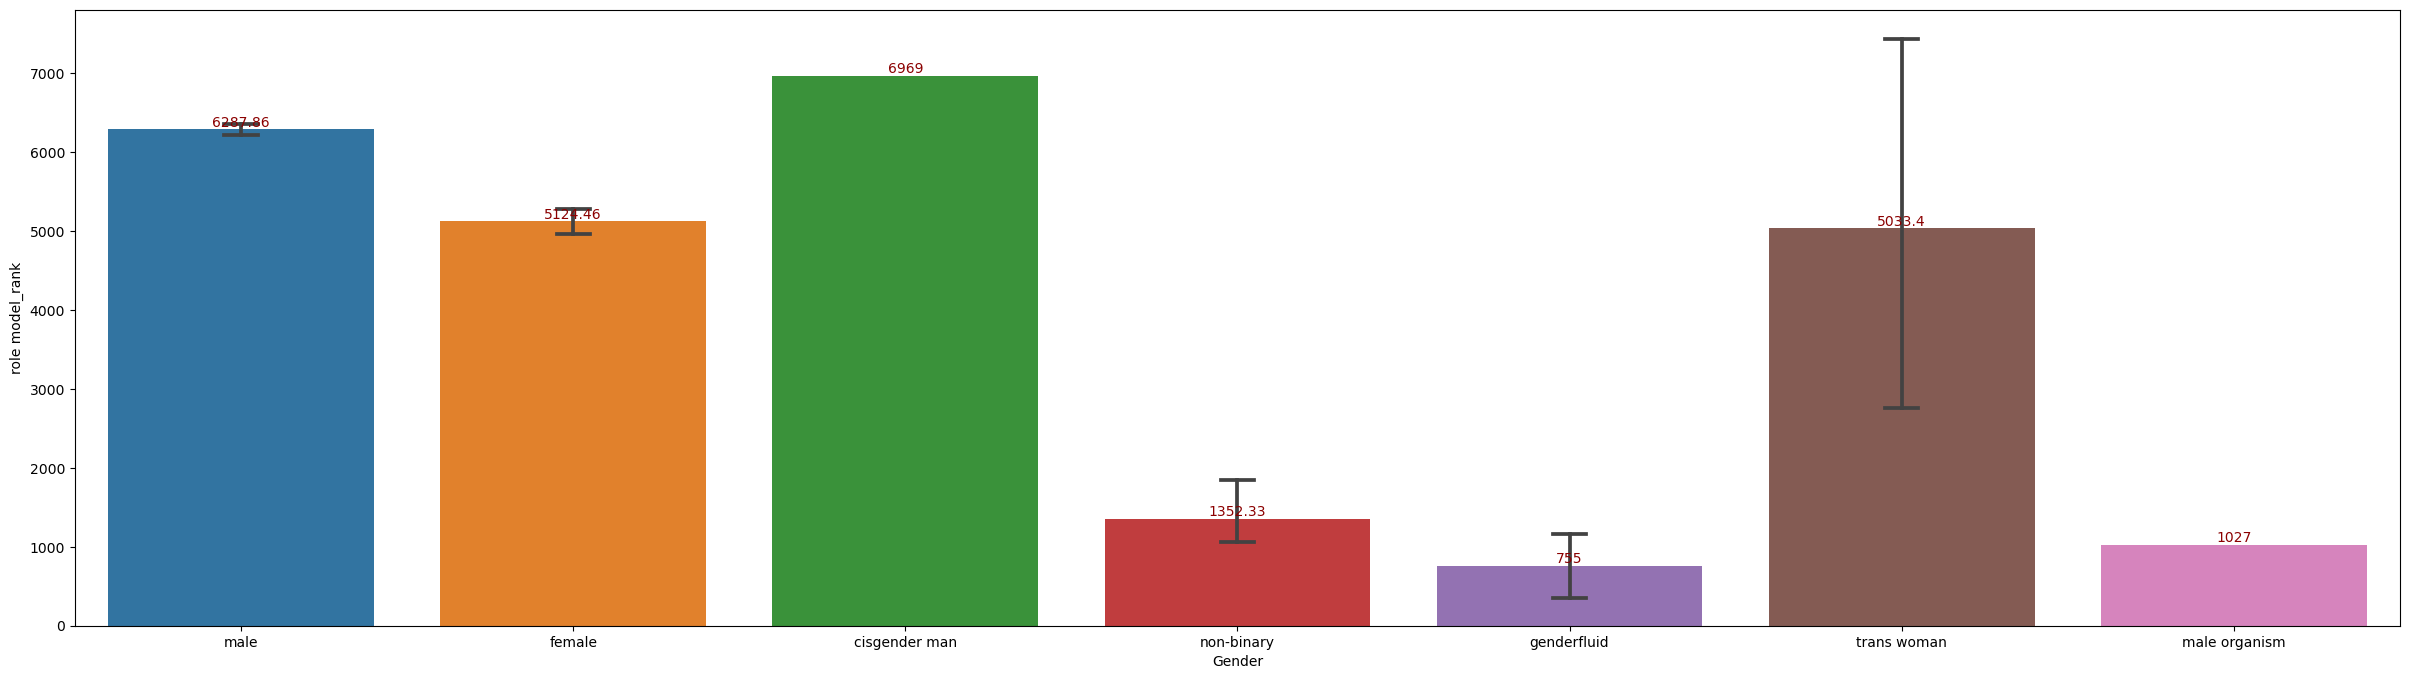

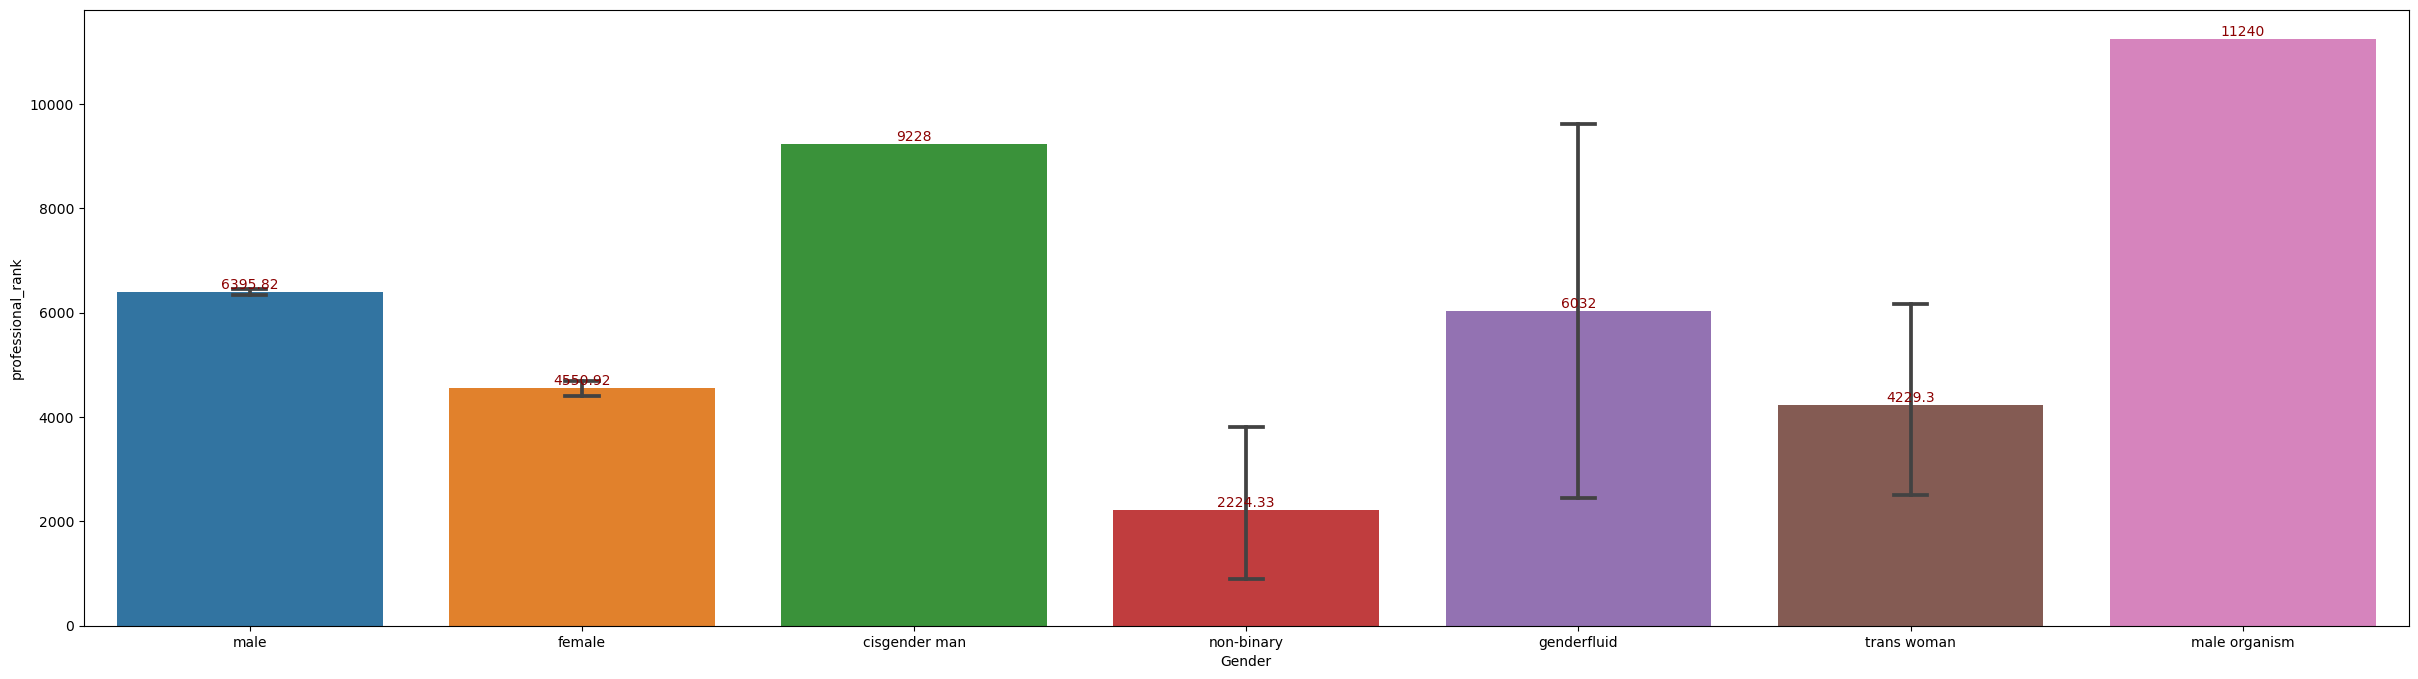

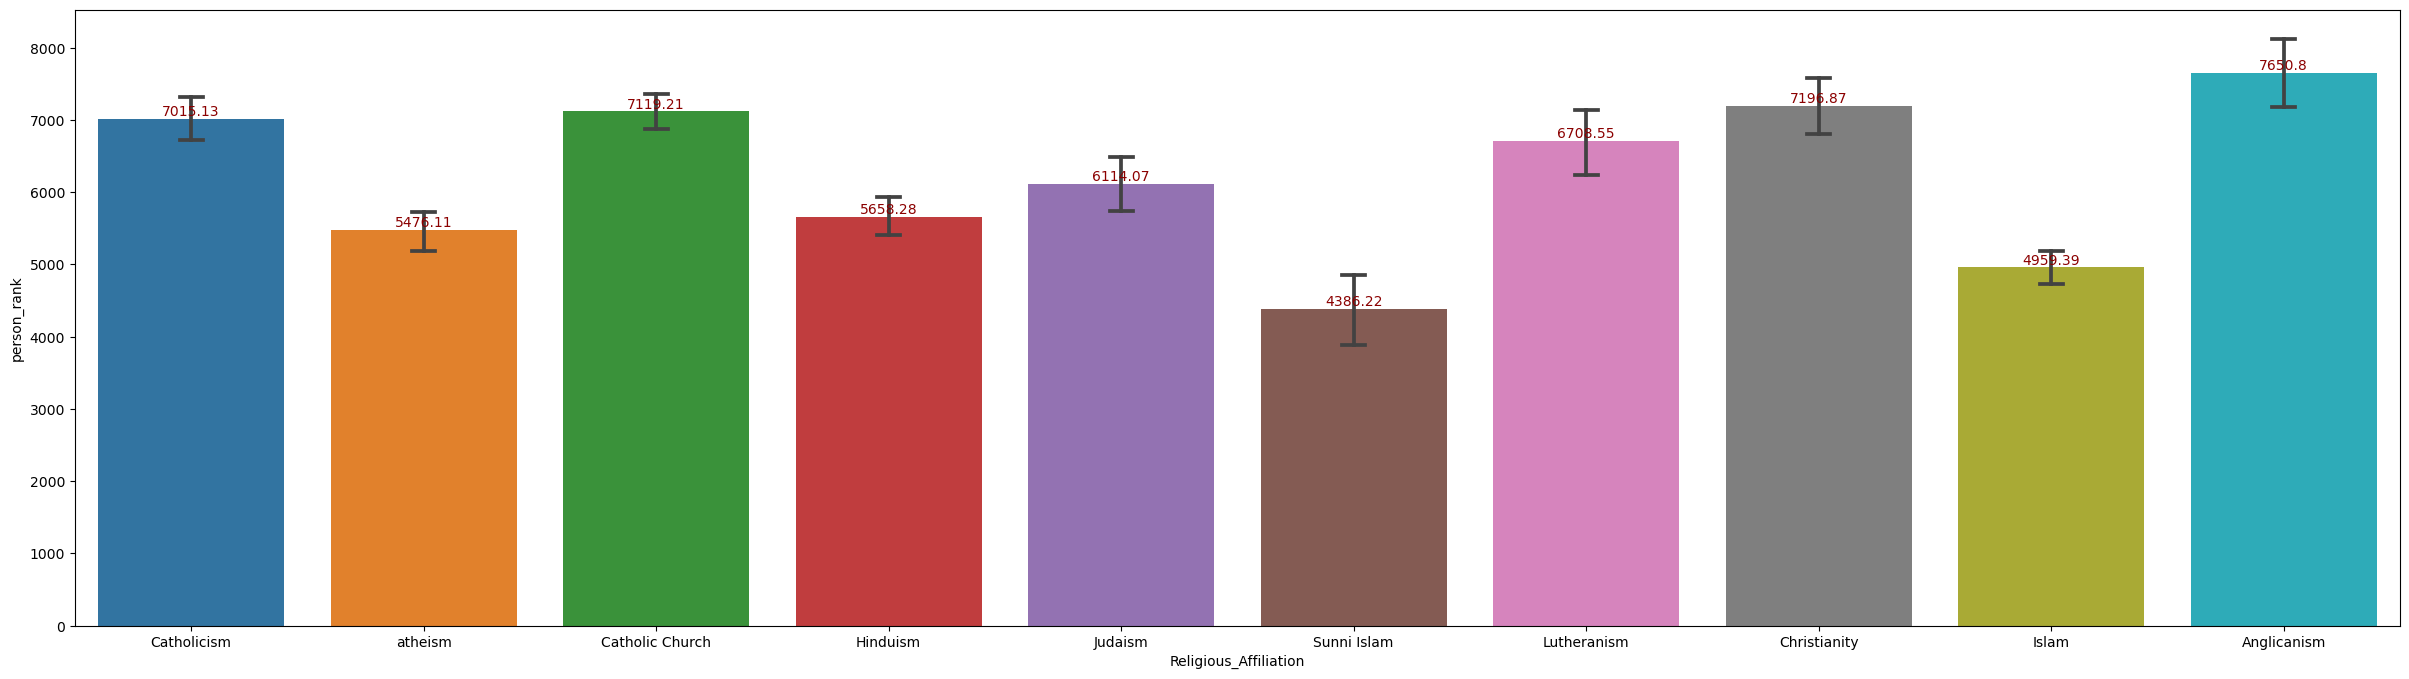

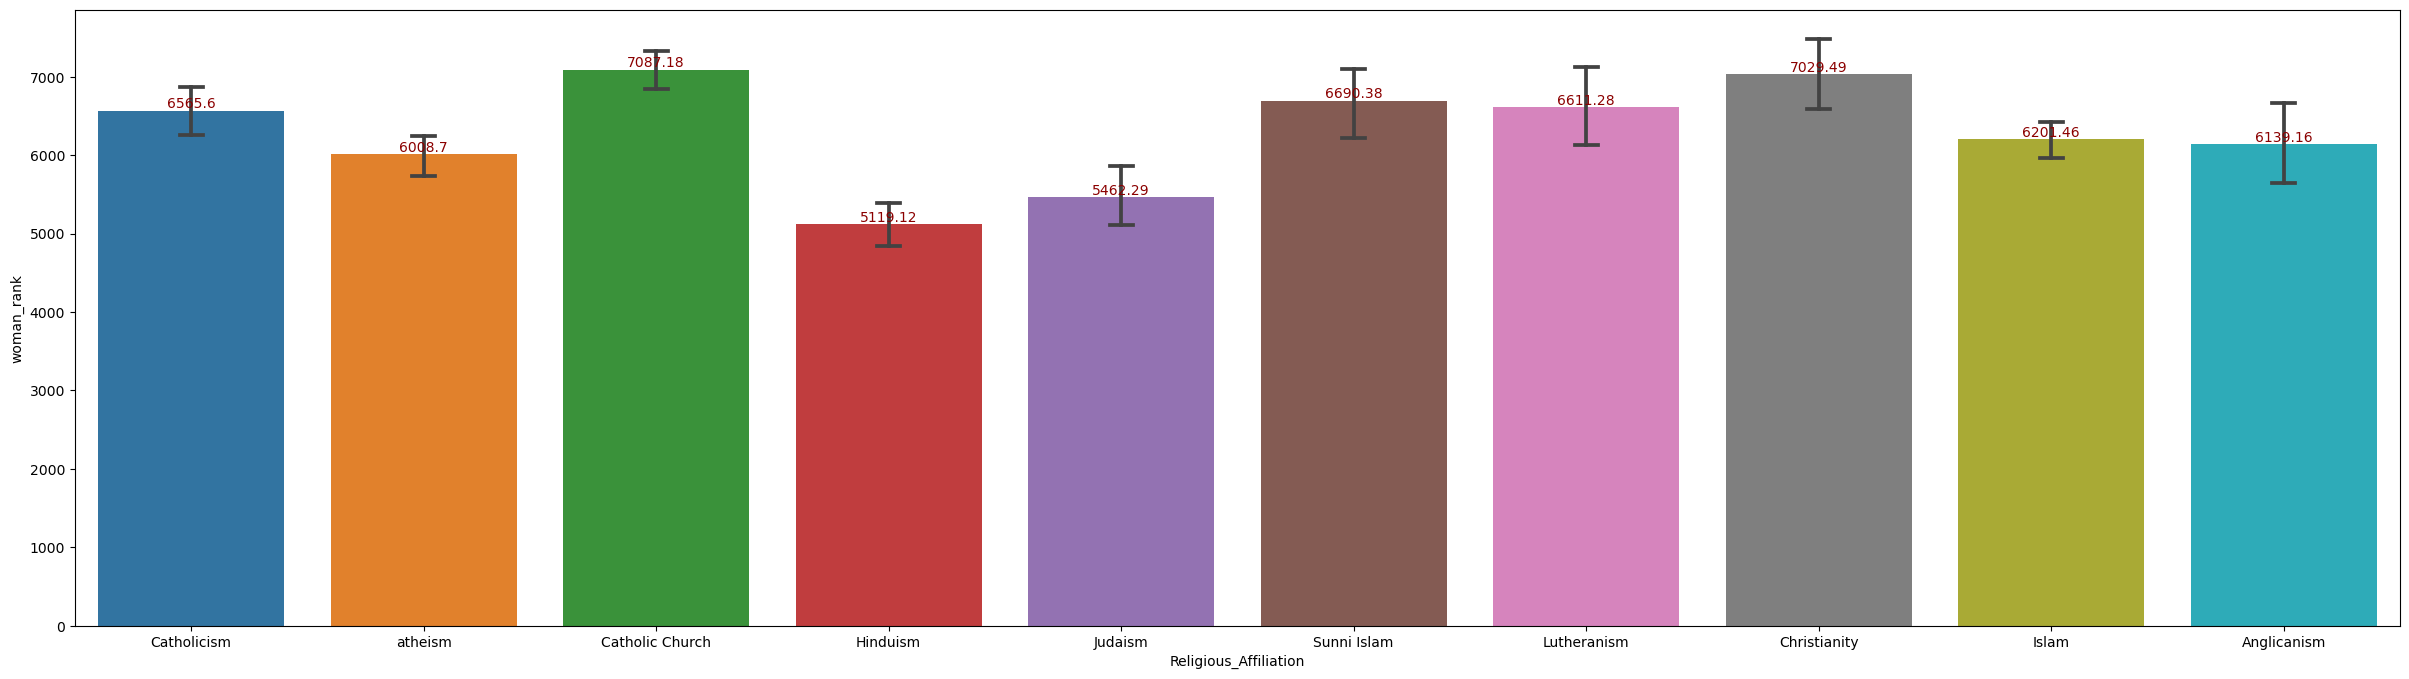

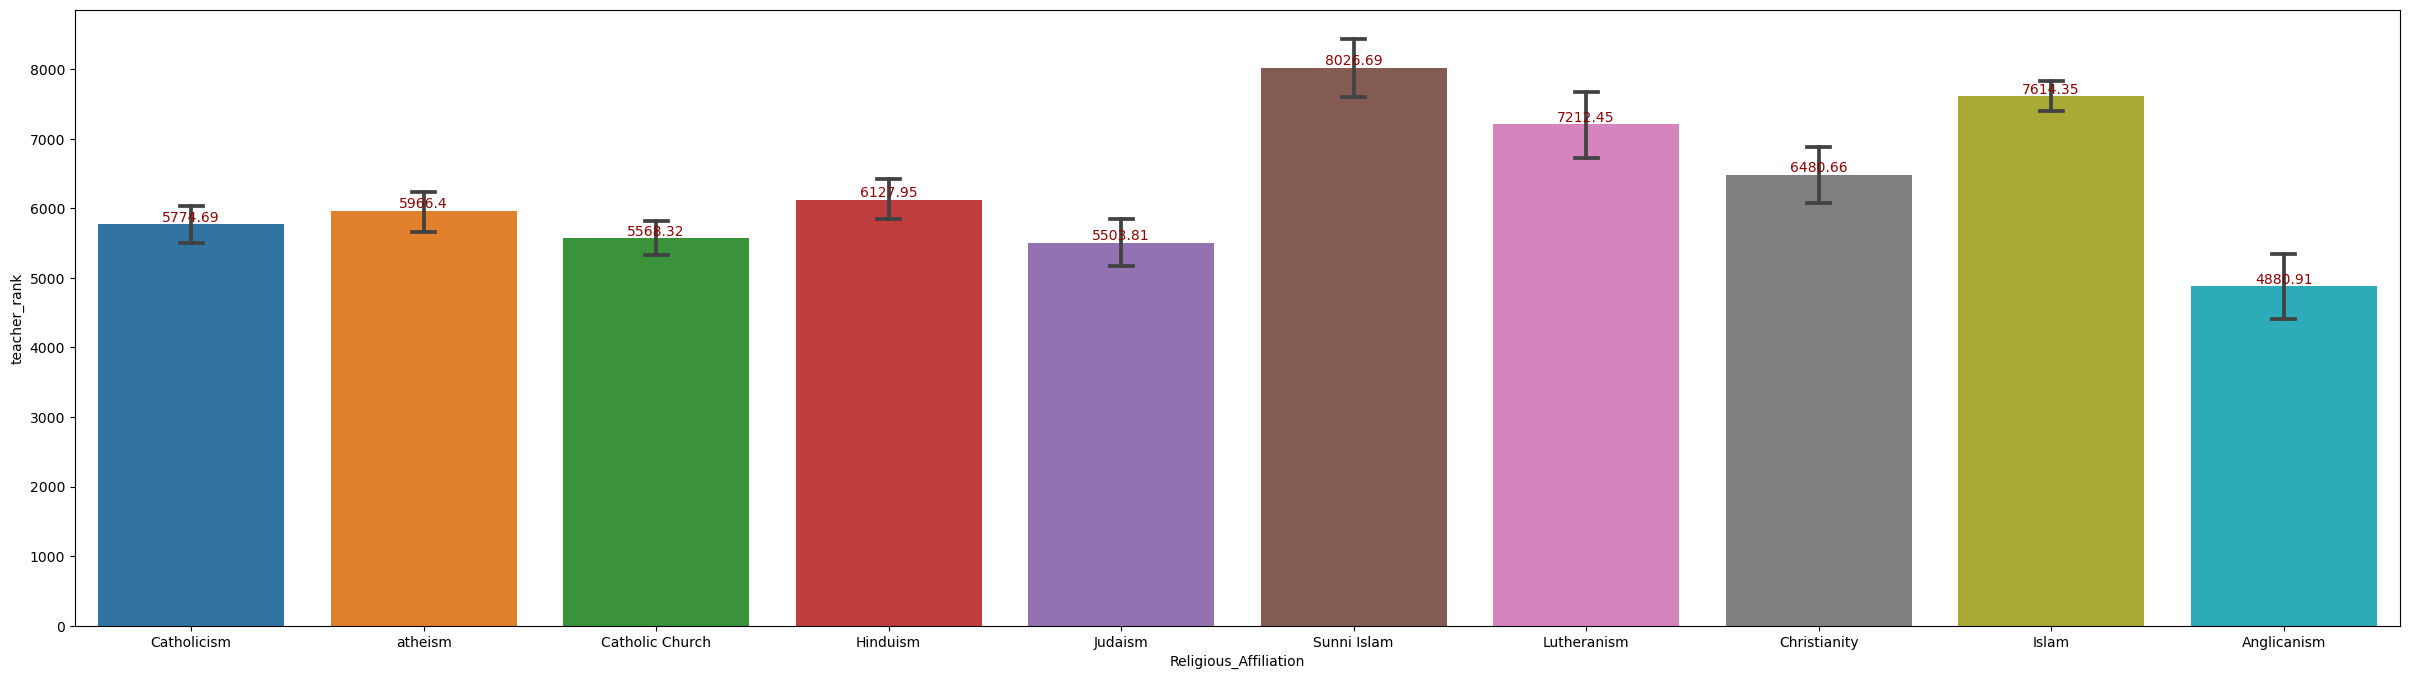

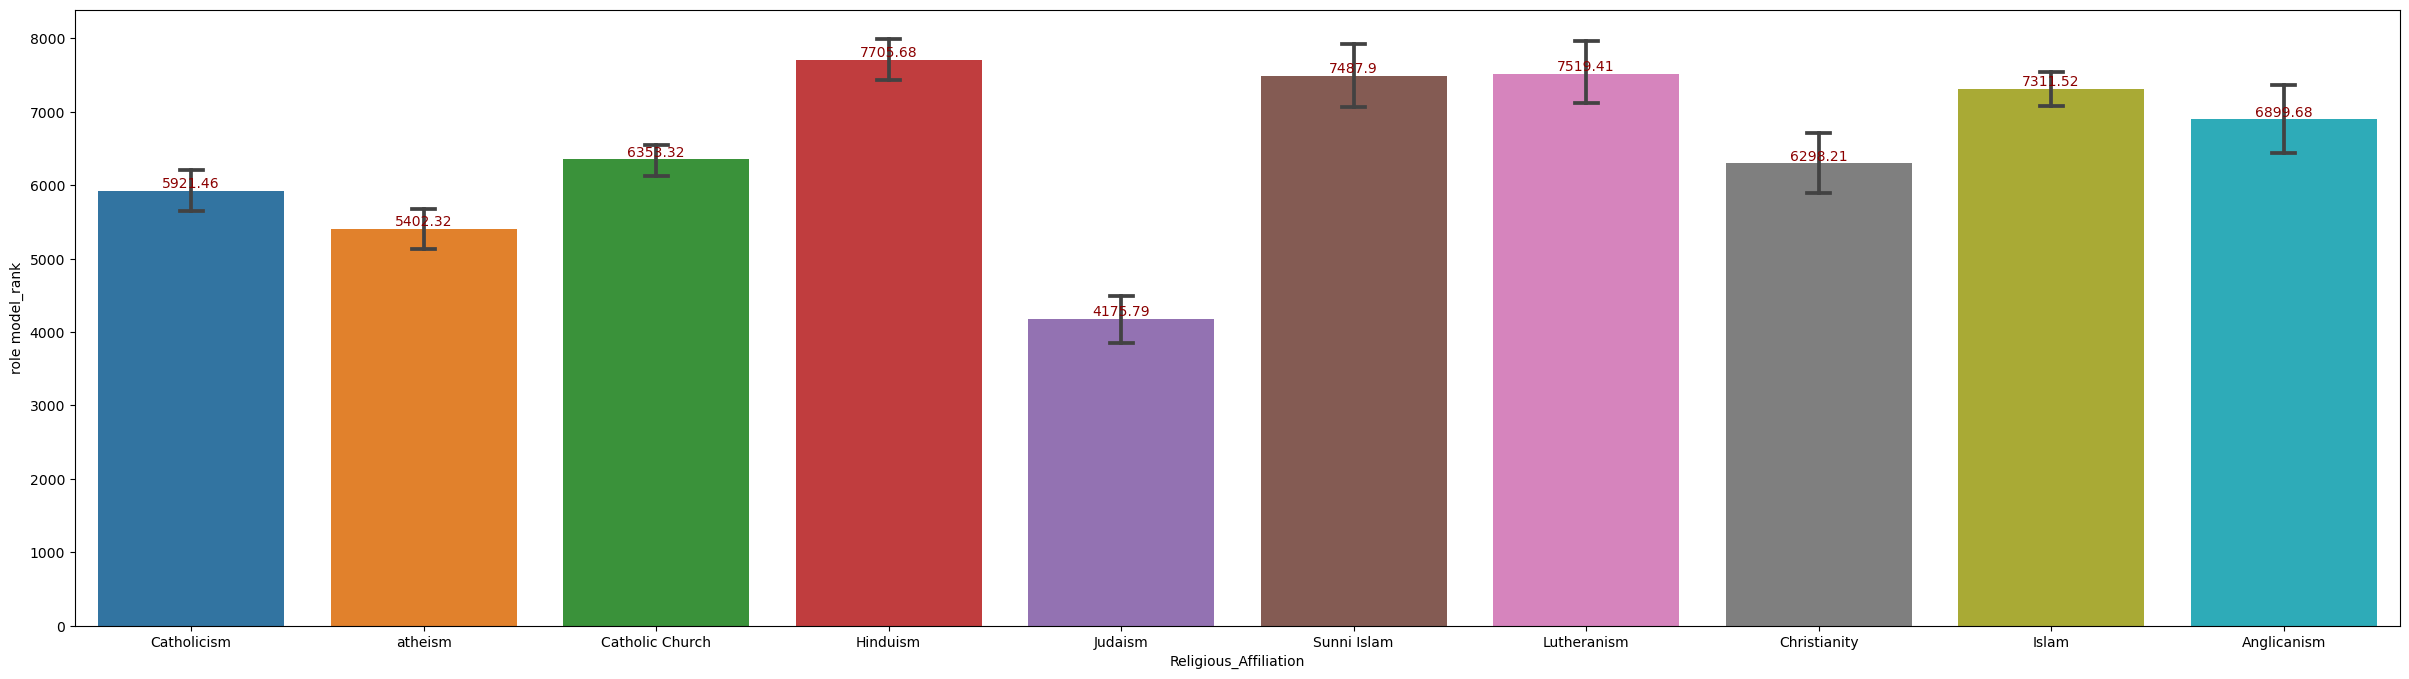

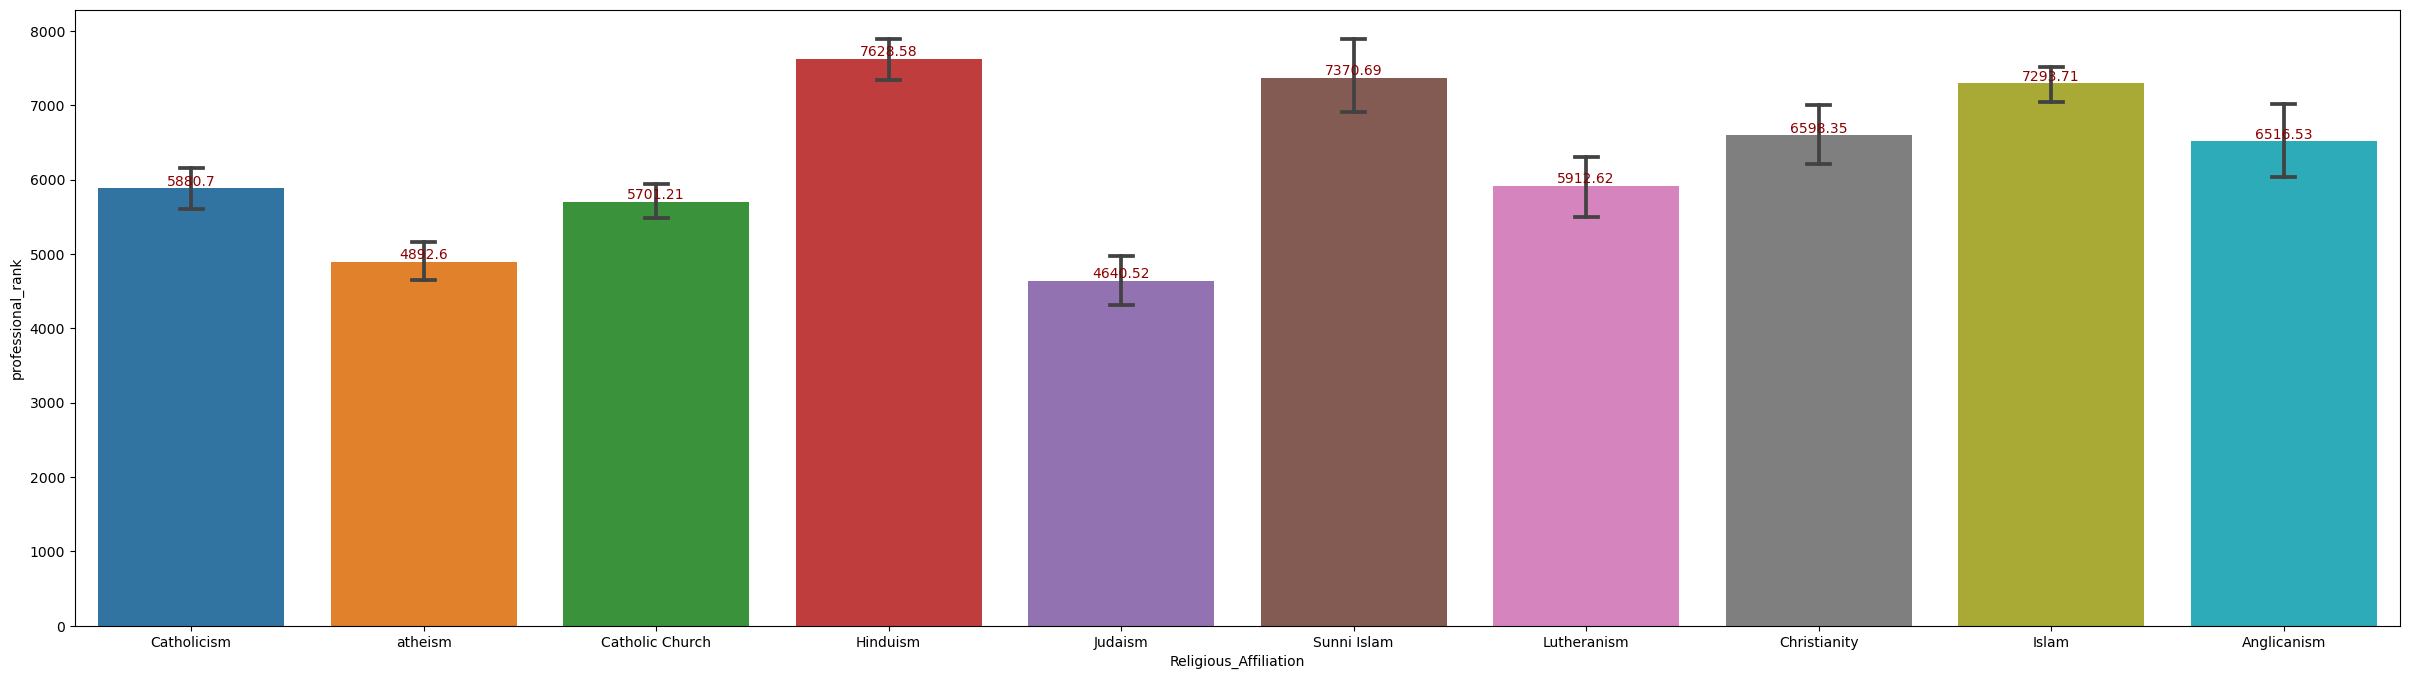

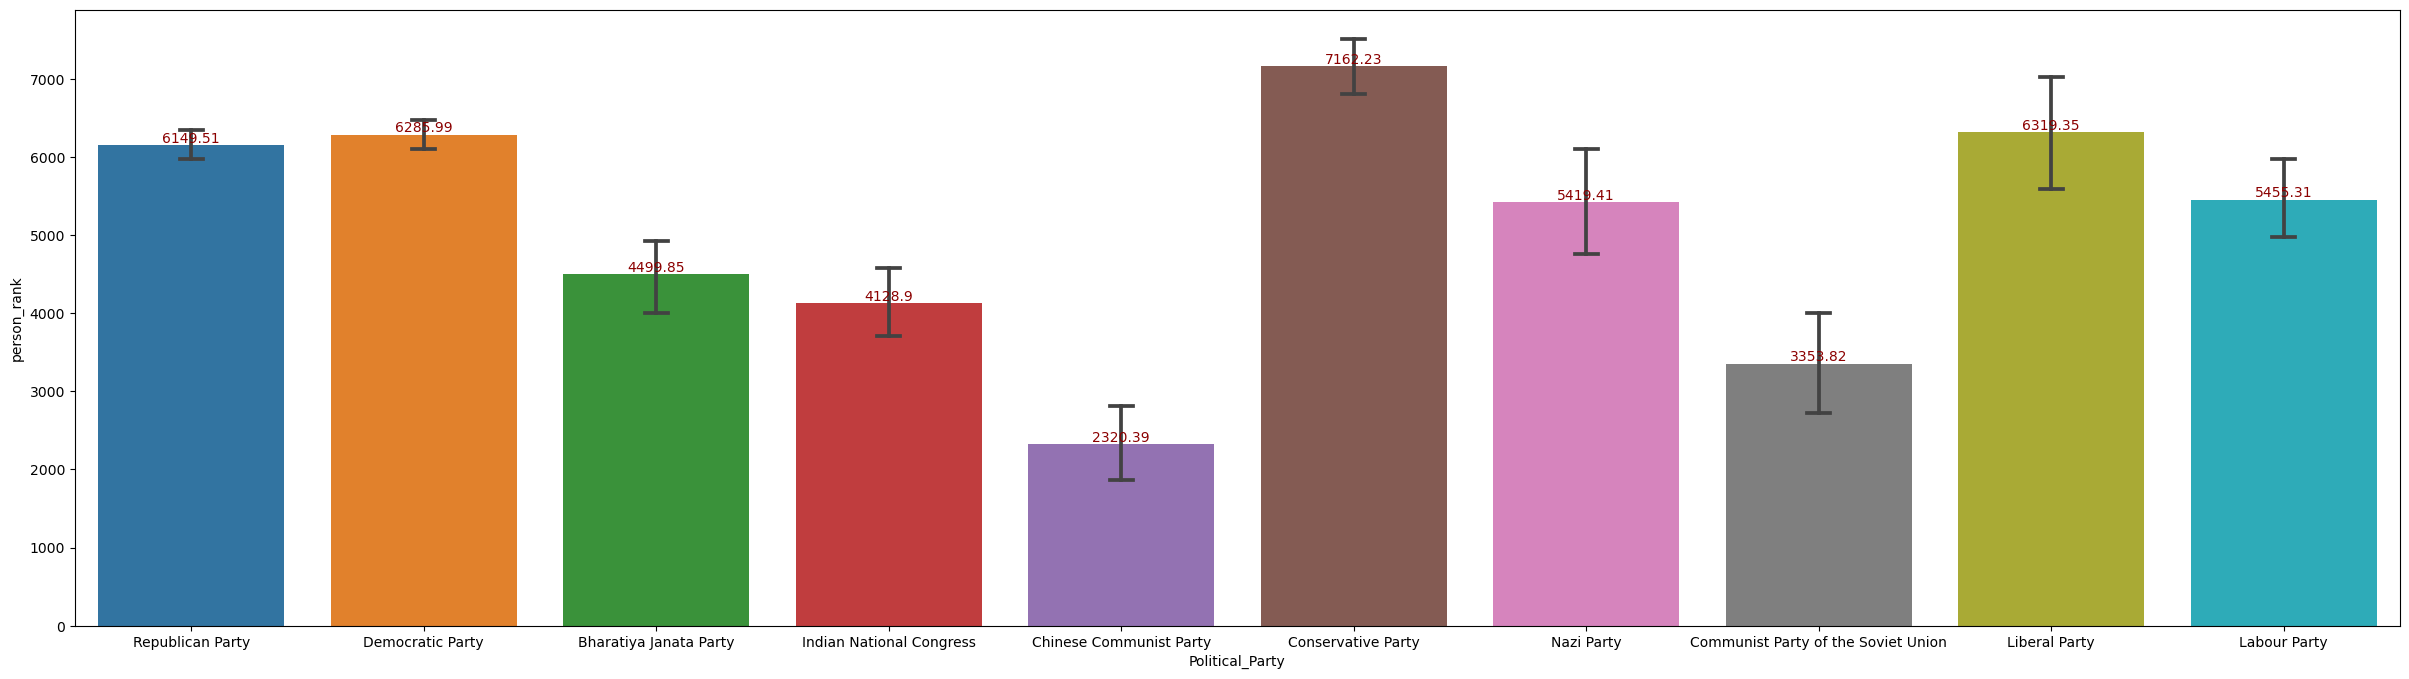

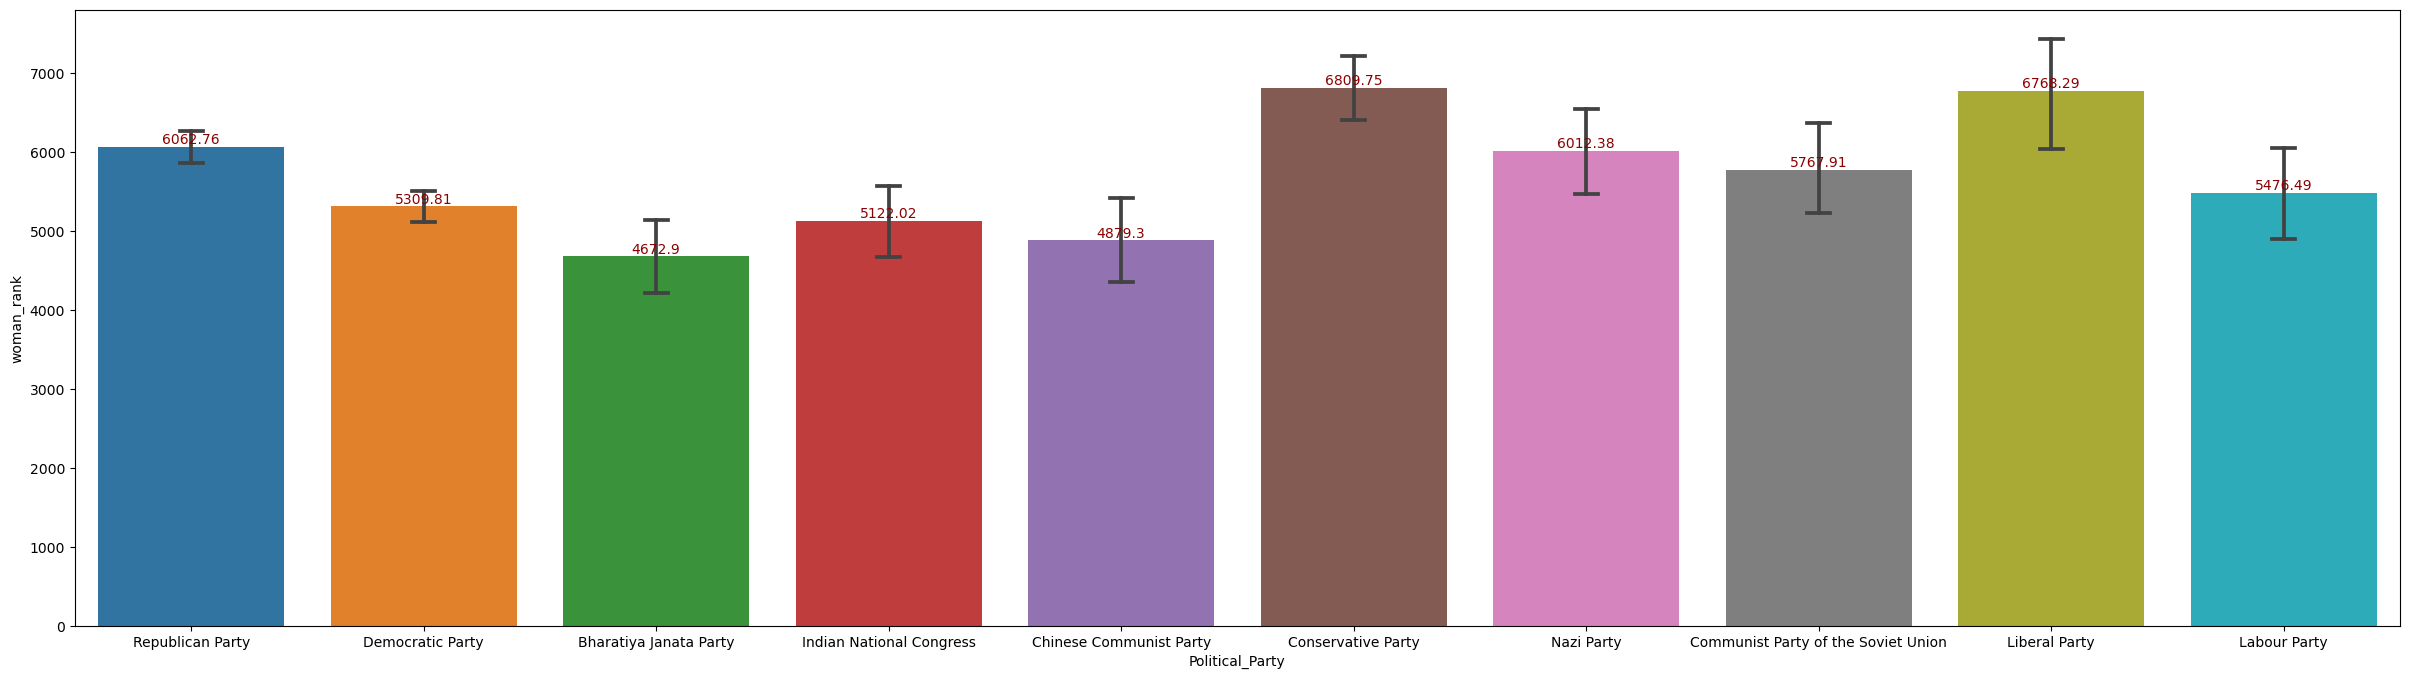

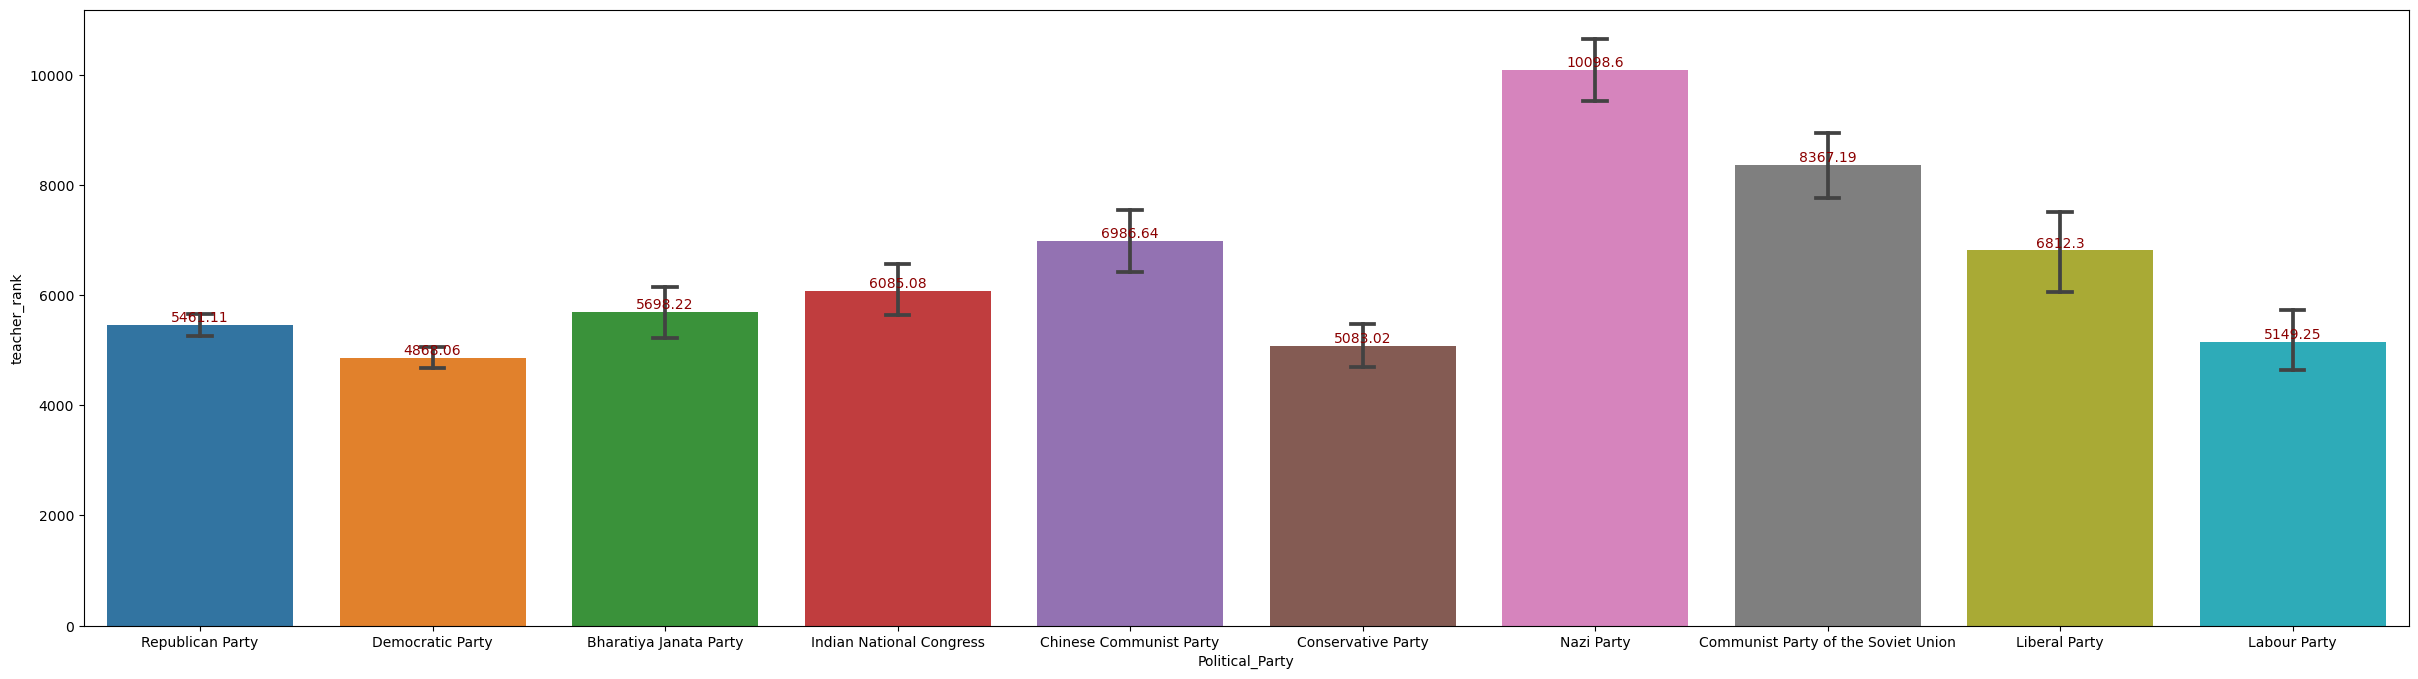

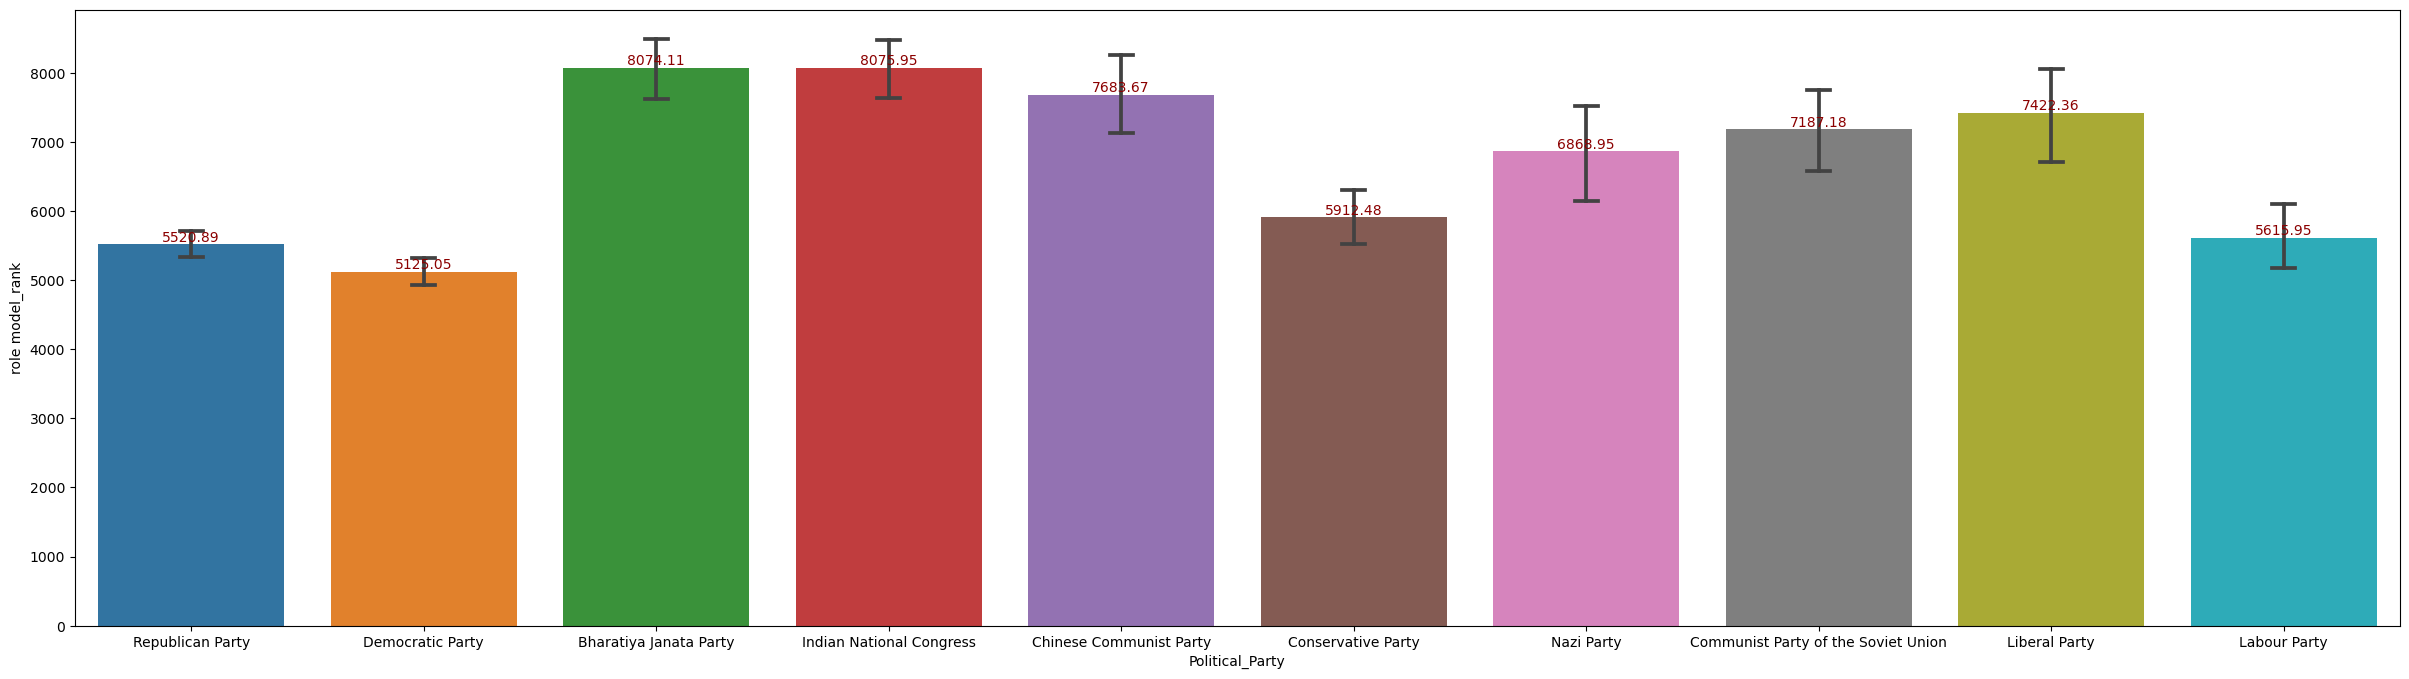

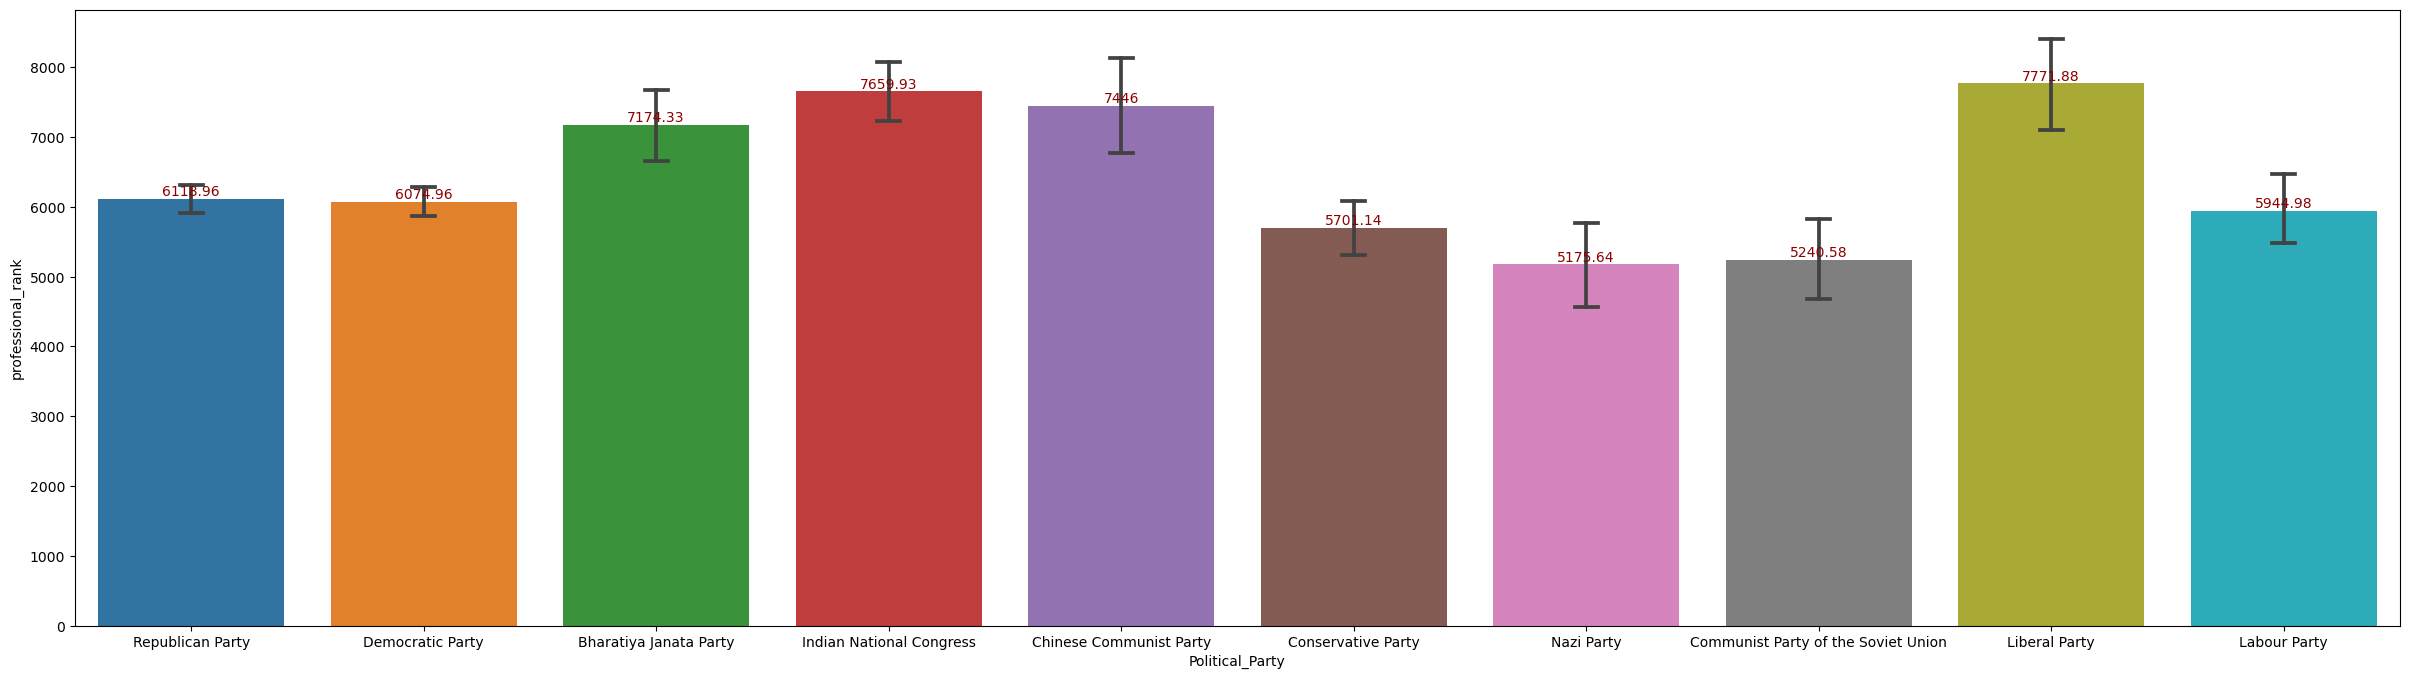

In [28]:
import os
if not os.path.exists('plots'):
    os.mkdir('plots')

attr_names = ['Ethnicity', 'Gender', 'Religious_Affiliation', 'Political_Party']
for attr_name in attr_names:
    top_10_categories = top_10_attributes[attr_name]
    filtered_df = person_attr_df[person_attr_df[attr_name].isin(top_10_categories.keys())]
    for query in queries:
        plt.figure(figsize=(30, 8))
        ax = sns.barplot(data=filtered_df, x=attr_name, y=query + "_rank", errorbar='ci', capsize=.1)
        ax.bar_label(ax.containers[0], fontsize=10, color='darkred')
        plt.savefig(f"plots/{attr_name}_{query}.png", dpi=300, bbox_inches='tight')

### Cross-Encoder Ranking and Re-training

In [29]:
# Create the feature extractor. This will be used by both pipelines
cescorer = CrossEncoderScorer(raw_text_dict)
fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
                         preprocessor, stopwords, recognized_categories,
                         network_features, cescorer)
p5_vector_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5', encoded_docs, document_ids)
p5_pipeline = L2RRanker(main_index, title_index, preprocessor,
                        stopwords, p5_vector_ranker, fe)

In [30]:
p5_pipeline.train(RELEVANCE_TRAIN_DATA)
p5_pipeline.model.save('p5_pipeline_l2r.txt')

Preparing: 100%|██████████| 129/129 [10:32<00:00,  4.91s/it]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2894
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 124


### Problem 5

In [31]:
p5_pipeline_info = run_relevance_tests(test_filename, p5_pipeline)

100%|██████████| 37/37 [04:39<00:00,  7.56s/it]


In [57]:
data = {}
with open('pipeline_info.json', 'r') as f:
    data = json.load(f)
    data['p5_pipeline'] = p5_pipeline_info

with open('pipeline_info.json', 'w') as f:
    json.dump(data, f, indent=4)

metric,map,ndcg
model,,
base,0.043913,0.332071
l2r,0.070226,0.343751
new_model,0.059102,0.333798


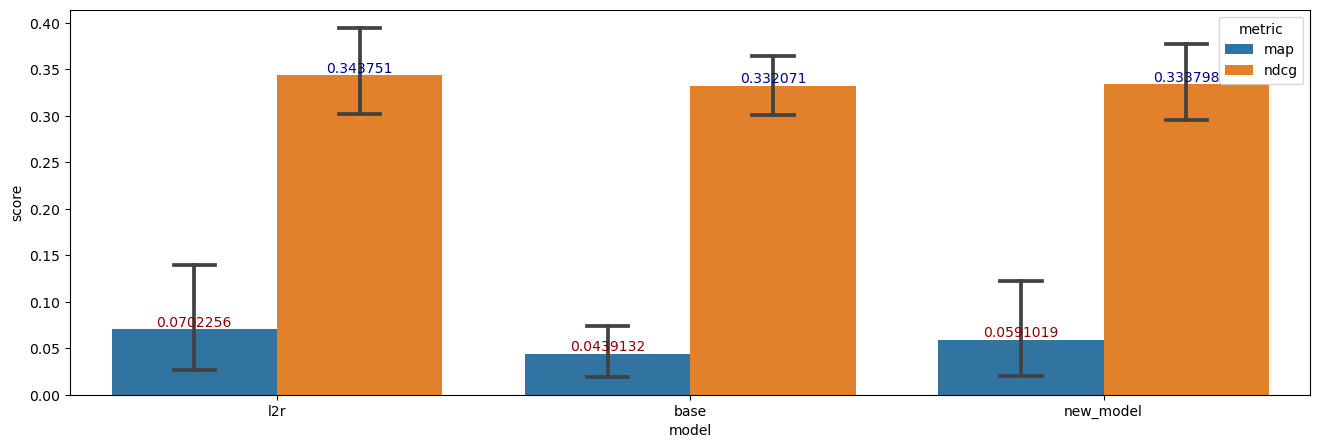

In [58]:
pipeline_df = pd.DataFrame(data).transpose().reset_index().rename(columns={'index': 'model'})
pipeline_df['score'] = pipeline_df[['map_scores', 'ndcg_scores']].apply(lambda x: metric_add_func(x[0], 'map') + metric_add_func(x[1], 'ndcg'), axis=1)
pipeline_df = pipeline_df.explode('score')
pipeline_df.drop(columns=['map', 'ndcg', 'map_scores', 'ndcg_scores'], inplace=True)
pipeline_df['metric'] = pipeline_df['score'].apply(lambda x: x[0])
pipeline_df['score'] = pipeline_df['score'].apply(lambda x: x[1])
pipeline_df['model'] = pipeline_df['model'].apply(lambda x: "new_model" if x == "p5_pipeline" else x)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=pipeline_df, x='model', y='score', hue='metric', capsize=.1, errorbar='ci')
ax.bar_label(ax.containers[0], fontsize=10, color='darkred')
ax.bar_label(ax.containers[1], fontsize=10, color='darkblue')
plt.savefig('pipeline_metrics.png', dpi=300, bbox_inches='tight')
pipeline_df.pivot_table(index='model', columns='metric', values='score', aggfunc='mean')

### Problem 4

In [35]:
sampled_queries = [
    "What is the history and cultural importance of traditional Chinese martial arts",
    "How are countries responding to the challenges of misinformation and disinformation campaigns",
    "Analyze the role of architecture in promoting sustainability and green design",
    "How do colleges and universities ensure campus safety and security",
    "How have smartphones influenced the gaming industry and mobile gaming trends"
]

dev_df = pd.read_csv(RELEVANCE_DEV_DATA)

q4_vec_encoder = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5', encoded_docs, document_ids)
cescorer = CrossEncoderScorer(raw_text_dict)

total_biencoder_scores = []
total_cross_scores = []
total_biencoder_ranks = []
total_cross_ranks = []

for query in tqdm(sampled_queries):
    docids = dev_df[dev_df['query'] == query]['docid'].values
    biencoder_scores = q4_vec_encoder.query(query)
    biencoder_scores = {k: v for k, v in biencoder_scores}
    biencoder_scores = [biencoder_scores[docid] for docid in docids]
    biencoder_ranks = np.argsort(biencoder_scores)[::-1]
    biencoder_ranks = [v + 1 for v in biencoder_ranks]
    cross_scores = []
    for docid in docids:
        cross_score = cescorer.score(docid, query)
        cross_scores.append(cross_score)
    cross_ranks = np.argsort(cross_scores)[::-1]
    cross_ranks = [v + 1 for v in cross_ranks]

    total_biencoder_scores.extend(biencoder_scores)
    total_cross_scores.extend(cross_scores)
    total_biencoder_ranks.extend(biencoder_ranks)
    total_cross_ranks.extend(cross_ranks)

100%|██████████| 5/5 [01:00<00:00, 12.04s/it]


##### Spearman

In [36]:
from scipy.stats import spearmanr
spearmanr(total_biencoder_scores, total_cross_scores)[0]

0.5829088970291739

##### Scatter plot

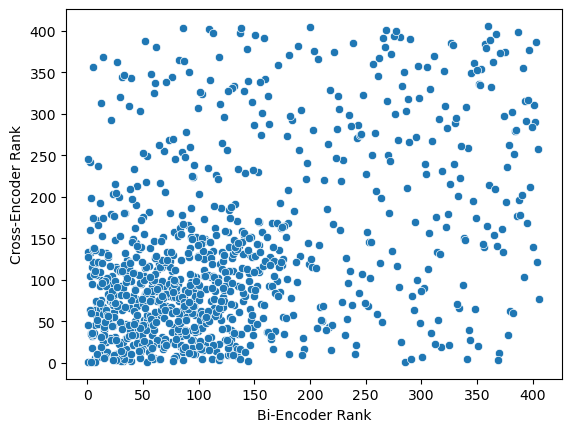

In [37]:
sns.scatterplot(x=total_biencoder_ranks, y=total_cross_ranks)
plt.xlabel("Bi-Encoder Rank")
plt.ylabel("Cross-Encoder Rank")
plt.savefig("bi_cross_rank_scatter.png", dpi=300, bbox_inches='tight')

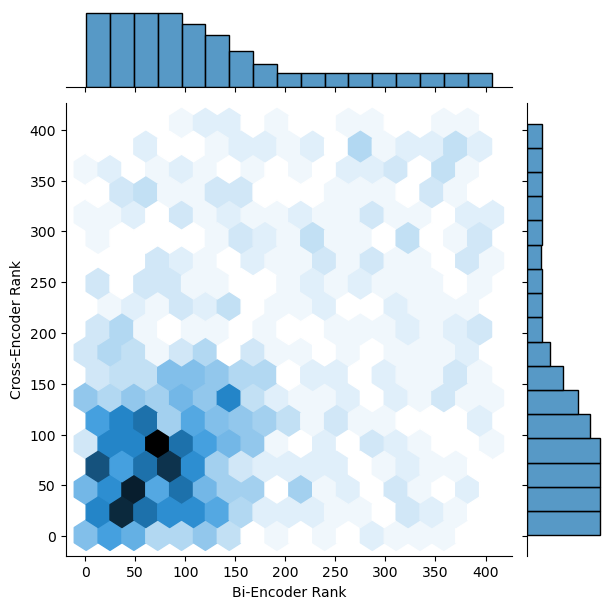

In [38]:
sns.jointplot(x=total_biencoder_ranks, y=total_cross_ranks, kind='hex')
plt.xlabel("Bi-Encoder Rank")
plt.ylabel("Cross-Encoder Rank")
plt.savefig("bi_cross_rank_hex.png", dpi=300, bbox_inches='tight')

### Explorations

In [39]:
import requests

def get_wiki_title(page_id:int):
    url = (
        'https://en.wikipedia.org/w/api.php'
        '?action=query'
        '&prop=info'
        '&inprop=subjectid'
        f'&pageids={page_id}' 
        '&format=json')
    json_response = requests.get(url).json()
    return json_response['query']['pages'][str(page_id)]['title']

In [40]:
bm25 = BM25(main_index)
ranker = Ranker(main_index, preprocessor, stopwords, bm25)

pipeline_1 = L2RRanker(main_index, title_index, preprocessor,
                       stopwords, ranker, fe)

pipeline_1.train(RELEVANCE_TRAIN_DATA)
pipeline_2 = p5_pipeline

Preparing: 100%|██████████| 129/129 [11:10<00:00,  5.20s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2894
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 124


In [45]:
pipeline_1_info = run_relevance_tests(test_filename, pipeline_1)

100%|██████████| 37/37 [05:03<00:00,  8.21s/it]


In [59]:
data['pipeline_1'] = pipeline_1_info

After this point, students may have varying answers and observations depending on their implementation and their own features. So, your mileage may vary (YMMV)

### Example Query: 'How did the Mongols conquer China?'

This query should lead to pages about the different Mongolian invasions of China (there were multiple).

In [41]:
[(get_wiki_title(doc), score) for doc, score in pipeline_1.query('How did the Mongols conquer China?')[:10]]

[('Mongols', 0.1534867083343878),
 ('Mongols in China', 0.14939814740461801),
 ('Proto-Mongols', 0.13488855374070305),
 ('Mongol conquest of China', 0.09367380611897755),
 ('Foreign relations of imperial China', 0.08780048296061391),
 ('Mongol Empire', 0.07443215906076774),
 ('Möngke Khan', 0.07443215906076774),
 ('Subutai', 0.07443215906076774),
 ('Mongol invasion of Europe', 0.07443215906076774),
 ('Chinese expansionism', 0.07443215906076774)]

In [42]:
[(get_wiki_title(doc), score) for doc, score in pipeline_2.query('How did the Mongols conquer China?')[:10]]

[('Mongols in China', 0.14939814740461801),
 ('Proto-Mongols', 0.13488855374070305),
 ('Mongol conquest of China', 0.09367380611897755),
 ('Foreign relations of imperial China', 0.08780048296061391),
 ('Mongol Empire', 0.07443215906076774),
 ('Mongol invasion of Europe', 0.07443215906076774),
 ('Chinese expansionism', 0.07443215906076774),
 ('Mongolia under Qing rule', 0.07443215906076774),
 ('Mongol invasions of Vietnam', 0.07443215906076774),
 ('Northern Yuan', 0.07443215906076774)]

**The first result is pretty similar**

But the difference is in what lies after maybe the second rank. You would see that the vector ranker would provide better pages overall in the top ranks of the fetched document list (in our experience the vector ranker pipeline focused more on conquests by mongols rather than details about mongols themselves).

### Example of a query where both the pipelines perform badly

**top 10 video games** 

In [43]:
[(get_wiki_title(doc), score) for doc, score in pipeline_1.query('top 10 video games')[:10]]

[('2013 in video games', 0.1216225696943588),
 ('2016 in video games', 0.1216225696943588),
 ('2019 in video games', 0.07510120087440691),
 ('Breakout (video game)', 0.07346076771181355),
 ('Night Driver (video game)', 0.07346076771181355),
 ('Tile-based video game', 0.07346076771181355),
 ('Video games in the United States', 0.07174534830464477),
 ('Melee (game terminology)', 0.0675875955353886),
 ('Isometric video game graphics', 0.06594716237279524),
 ('Golden age of arcade video games', 0.06508593454307408)]

In [44]:
[(get_wiki_title(doc), score) for doc, score in pipeline_2.query('top 10 video games')[:10]]

[('2013 in video games', 0.1216225696943588),
 ('2016 in video games', 0.1216225696943588),
 ('2019 in video games', 0.07510120087440691),
 ('Video games in the United States', 0.07174534830464477),
 ('Sports video game', 0.06344550138048073),
 ('Programming game', 0.059843312521335956),
 ('Casual game', 0.05741390132008401),
 ('Video games in China', 0.05616637171283598),
 ('2010s in video games', 0.053310958400683894),
 ('Video game genre', 0.04758889800187939)]

Looking at the results, it doesn't seem that the search engine does very well on this query. Why might that be? Could you think of ways to handle these types of queries? What about other queries where the search engine might just not be very good?

### **Ablation Study** (What have been/can be done?)
- BM25 (hw2)
  - None: base
  - l2rranker: l2r
- l2rranker + index_augment + cross_encoder
  - BM25: pipeline_1
  - VectorRanker: pipeline_2
- vector_ranker + l2rranker
  - index: pipeline_3
  - index_augment: pipeline_4
- vector_ranker + l2rranker + index_augment
  - None: pipeline_4
  - cross_encoder: pipeline_2

In [51]:
ORIGIN_INDEX = "main_index"
origin_index = Indexer.load_index(ORIGIN_INDEX)
cescorer = None
fe = L2RFeatureExtractor(origin_index, title_index, doc_category_info,
            preprocessor, stopwords, recognized_categories,
            network_features, cescorer)

base_ranker = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5', encoded_docs, document_ids)
pipeline_3 = L2RRanker(origin_index, title_index, preprocessor,
                    stopwords, base_ranker, fe)
pipeline_4 = L2RRanker(main_index, title_index, preprocessor,
                    stopwords, base_ranker, fe)

load index: 100%|██████████| 122784/122784 [00:21<00:00, 5592.87it/s] 


In [52]:
pipeline_3.train(RELEVANCE_TRAIN_DATA)
pipeline_4.train(RELEVANCE_TRAIN_DATA)

Preparing: 100%|██████████| 129/129 [00:07<00:00, 16.60it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 123


Preparing: 100%|██████████| 129/129 [02:34<00:00,  1.19s/it]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 123


In [53]:
pipeline_3.model.save('pipeline_3_l2r.txt')
pipeline_4.model.save('pipeline_4_l2r.txt')
pipeline_3_info = run_relevance_tests(test_filename, pipeline_3)
pipeline_4_info = run_relevance_tests(test_filename, pipeline_4)

100%|██████████| 37/37 [01:22<00:00,  2.24s/it]


In [60]:
data['pipeline_3'] = pipeline_3_info
data['pipeline_4'] = pipeline_4_info

metric,map,ndcg
model,,
base,0.043913,0.332071
l2r,0.070226,0.343751
pipeline_1,0.052045,0.330412
pipeline_2,0.059102,0.333798
pipeline_3,0.046063,0.328585
pipeline_4,0.056367,0.331492


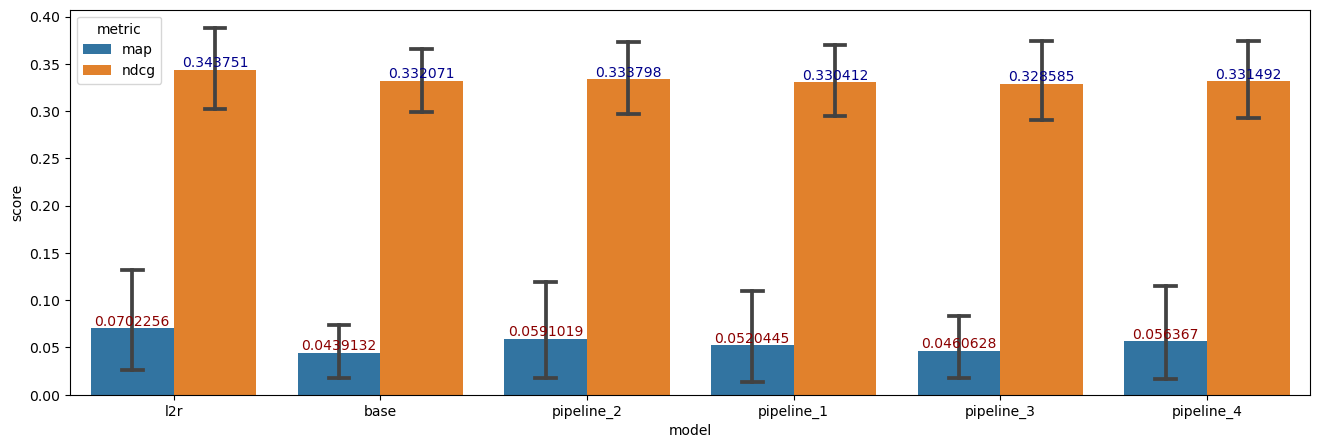

In [61]:
pipeline_df = pd.DataFrame(data).transpose().reset_index().rename(columns={'index': 'model'})
pipeline_df['score'] = pipeline_df[['map_scores', 'ndcg_scores']].apply(lambda x: metric_add_func(x[0], 'map') + metric_add_func(x[1], 'ndcg'), axis=1)
pipeline_df = pipeline_df.explode('score')
pipeline_df.drop(columns=['map', 'ndcg', 'map_scores', 'ndcg_scores'], inplace=True)
pipeline_df['metric'] = pipeline_df['score'].apply(lambda x: x[0])
pipeline_df['score'] = pipeline_df['score'].apply(lambda x: x[1])
pipeline_df['model'] = pipeline_df['model'].apply(lambda x: "pipeline_2" if x == "p5_pipeline" else x)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=pipeline_df, x='model', y='score', hue='metric', capsize=.1, errorbar='ci')
ax.bar_label(ax.containers[0], fontsize=10, color='darkred')
ax.bar_label(ax.containers[1], fontsize=10, color='darkblue')
plt.savefig('pipeline_metrics_extra.png', dpi=300, bbox_inches='tight')
pipeline_df.pivot_table(index='model', columns='metric', values='score', aggfunc='mean')

### **Ablation Study** (What have been/can be done?)
- BM25 (hw2)
  - None: base
  - l2rranker: l2r
- l2rranker + index_augment + cross_encoder
  - BM25: pipeline_1
  - VectorRanker: pipeline_2
- vector_ranker + l2rranker
  - index: pipeline_3
  - index_augment: pipeline_4
- vector_ranker + l2rranker + index_augment
  - None: pipeline_4
  - cross_encoder: pipeline_2


Pure VectorRanker:
- Dev MAP: 0.026905002891844994
- Dev NDCG: 0.3465734174740667
- Test MAP: 0.05954350277879689
- Test NDCG: 0.31400025741503784

In [ ]:
with open('pipeline_info_extra.json', 'w') as f:
    json.dump(data, f, indent=4)